In [1]:
import h5py
import os.path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gd
from utils.paths import SetupPaths
import matplotlib.patches as  mpatches
from matplotlib.ticker import FormatStrFormatter
from utils.get_summary_data import compile_summary
from utils.vectorCorrection import vectorCorrection as vector


paths = SetupPaths()

In [2]:
plt.show();
plt.rcParams.update({'font.size':20,"xtick.direction":"in","ytick.direction":"in", 
                     "xtick.top":True, "ytick.right":True,"text.usetex":False,
                     "xtick.labelsize":18,"ytick.labelsize":18})


In [3]:
# defining equivalent redshifts
zs = {"z":np.array([0,1,2,3,4]), 
#       "zill":np.array([135,85,68,60,56]), 
      "ztng":np.array([99,50,33,25,21])}

# defining color palette for plotting
palette = {"Illustris dark": "#009292", "Illustris hydro": "#B6DAFF",
           "TNG dark": "#930200", "TNG hydro": "#FFB5DC",
           "dwarf":"olive","massive":"salmon", "difference":"#2C1D11", "difference2":"#464646"}

alphas = {"maj": 0.7, "min": 0.3}


# Initialization

In [4]:
# make functions to get data at the requested snapshot
def get_primmask(primstells, size):
    if size == "dwarf":
        mask = (primstells > 0.01) & (primstells < 0.5)
    elif size == "massive":
        mask = (primstells > 0.5) & (primstells < 10)
    return mask

def get_groupmask(groupmass, size):
    if size == "dwarf":
        mask = (groupmass > 8) & (groupmass < 50)
    elif size == "massive":
        mask = (groupmass > 100) & (groupmass < 650)
    return mask

In [5]:
class EmptyFile(Exception): pass
class SkipRedshift(Exception): pass


# Primary + Pair count

In [12]:
size = "dwarf"
errorprint=False    
redshiftcutoff=True
snapshots = np.arange(0,100,1)
snapshots = np.delete(snapshots, np.where(snapshots==48)[0])
redcutoff = 4.2

redshifts = []
medone, medtwo, medtot, medmaj, medmin, medpair, medmajfrac, medminfrac, medtotfrac = [], [], [], [], [], [], [], [], []
quartone, quarttwo, quarttot, quartmaj, quartmin, quartpair, quartmajfrac, quartminfrac, quarttotfrac = [], [], [], [], [], [], [], [], []

for snap in snapshots:  
    singleprims, doubleprims, totalprims = [], [], []
    majorpairs, minorpairs, totalpairs = [], [], []
    majfrac, minfrac, totfrac = [], [], []

    try:
        pair_path = f"TNG_{snap}_100.hdf5"
        pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")

        if np.size(pair_data) == 0:
            raise EmptyFile

        redshift = pair_data['Header'].attrs['Redshift']

        if redshiftcutoff & ( redshift > redcutoff) :
            raise SkipRedshift

        if (len(pair_data['pairs']["hydro"]['Group ID']) == 0):    
            raise EmptyFile

        unpair = pair_data["unpaired"]["hydro"]
        unpairStells = np.array(unpair["Sub1 Stellar Mass"])
        unpairGroups = np.array(unpair["Group Mass"])
        unpairReals = np.array(unpair['Realization'])

        pair = pair_data["pairs"]["hydro"]
        priStell = np.array(pair["Sub1 Stellar Mass"])
        secStell = np.array(pair["Sub2 Stellar Mass"])
        pairGroups = np.array(pair["Group Mass"])
        pairReals = np.array(pair["Realization"])
        seps = np.array(pair["Separation"]) 

        # subset masks for unpaired
        unpair_pri = get_primmask(unpairStells, size)
        unpair_group = get_groupmask(unpairGroups, size)                

        pair_pri = get_primmask(priStell, size)
        pair_group = get_groupmask(pairGroups, size)

        majors = (secStell/priStell > 1/4)
        minors = (secStell/priStell > 1/10) & (secStell/priStell < 1/4)
        allpairs = (majors + minors)
        pair_lowsep = (seps > 10)

        # defining combined masks 
        unpair_mask = unpair_pri & unpair_group
        primary_mask = pair_pri & pair_group
        pair_mask = pair_pri & pair_group & pair_lowsep & allpairs

        for real in np.unique(unpairReals):                  
            # make realization masks
            unpair_real = unpairReals == real
            pair_real = pairReals == real

            # make count values for single realization
            numone = np.count_nonzero(unpair_mask & unpair_real)
            numtwo = np.count_nonzero(primary_mask & pair_real)
            numtot = numone + numtwo
            nummaj = np.count_nonzero(pair_mask & pair_real & majors)
            nummin = np.count_nonzero(pair_mask & pair_real & minors)
            numpair = np.count_nonzero(pair_mask & pair_real)

            if numtot == 0:
                continue

            # collect count vals for all reals
            singleprims.append(numone)
            doubleprims.append(numtwo)
            totalprims.append(numtot)
            majorpairs.append(nummaj)
            minorpairs.append(nummin)
            totalpairs.append(numpair)
            majfrac.append(nummaj / numtot)
            minfrac.append(nummin / numtot)
            totfrac.append(numpair / numtot)

        # create arrays of medians and quartiles~ 
        lower, upper = 0.5, 99.5                
        redshifts.append( redshift )
        medone.append(np.median( singleprims ))
        medtwo.append(np.median( doubleprims ))
        medtot.append(np.median( totalprims ))
        medmaj.append(np.median( majorpairs ))
        medmin.append(np.median( minorpairs ))
        medpair.append(np.median( totalpairs ))
        medmajfrac.append(np.median( majfrac ))
        medminfrac.append(np.median( minfrac ))
        medtotfrac.append(np.median( totfrac ))   
        quartone.append( np.percentile( singleprims, [lower, upper]))
        quarttwo.append( np.percentile( doubleprims, [lower, upper]))
        quarttot.append( np.percentile( totalprims, [lower, upper]))
        quartmaj.append( np.percentile( majorpairs, [lower, upper]))
        quartmin.append( np.percentile( minorpairs, [lower, upper]))
        quartpair.append( np.percentile( totalpairs, [lower, upper]))
        quartmajfrac.append( np.percentile( majfrac, [lower, upper]))
        quartminfrac.append( np.percentile( minfrac, [lower, upper]))
        quarttotfrac.append( np.percentile( totfrac, [lower, upper]))

    except KeyError:
        if errorprint: print(f'skipping {snap} for KeyError. Please debug')
        continue

    except EmptyFile:
        if errorprint: print(f"skipping {snap}, empty file")
        continue

    except SkipRedshift:
        if errorprint: print(f"skipping {snap}, redshift out of range")

count_dictionary = {
        "z": np.array(redshifts),
        "Median Isolated Primaries": np.array(medone),
        "Median Noniso Primaries": np.array(medtwo),
        "Median Total Primaries": np.array(medtot),
        "Median Major Pairs": np.array(medmaj),
        "Median Minor Pairs": np.array(medmin),
        "Median All Pairs": np.array(medpair),
        "Median Major Fraction": np.array(medmajfrac),
        "Median Minor Fraction": np.array(medminfrac),
        "Median Total Fraction": np.array(medtotfrac),
        "Quarts Isolated Primaries": np.array(quartone),
        "Quarts Noniso Primaries": np.array(quarttwo),
        "Quarts Total Primaries": np.array(quarttot),
        "Quarts Major Pairs": np.array(quartmaj),
        "Quarts Minor Pairs": np.array(quartmin),
        "Quarts All Pairs": np.array(quartpair),
        "Quarts Major Fraction": np.array(quartmajfrac),
        "Quarts Minor Fraction": np.array(quartminfrac),
        "Quarts Total Fraction": np.array(quarttotfrac)}



In [16]:
count_dictionary.keys()

dict_keys(['z', 'Median Isolated Primaries', 'Median Noniso Primaries', 'Median Total Primaries', 'Median Major Pairs', 'Median Minor Pairs', 'Median All Pairs', 'Median Major Fraction', 'Median Minor Fraction', 'Median Total Fraction', 'Quarts Isolated Primaries', 'Quarts Noniso Primaries', 'Quarts Total Primaries', 'Quarts Major Pairs', 'Quarts Minor Pairs', 'Quarts All Pairs', 'Quarts Major Fraction', 'Quarts Minor Fraction', 'Quarts Total Fraction'])

[]

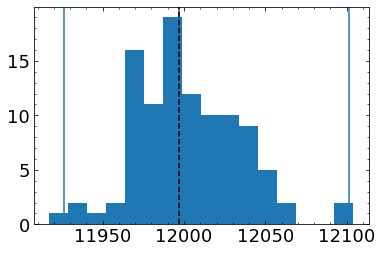

In [21]:
plt.hist(totalprims)
plt.axvline(count_dictionary["Median Total Primaries"][-1])
plt.axvline(count_dictionary["Quarts Total Primaries"][-1][0])
plt.axvline(count_dictionary["Quarts Total Primaries"][-1][1])
plt.axvline(np.median(totalprims),color="black",linestyle="dashed")

plt.plot()

In [24]:
for i,j in zip([1,2],["dwarf",4]):
    print(i,j)

1 dwarf
2 4


In [25]:
xx = np.array(["10 Realizations","100 Realizations","1000 Realizations"])

In [26]:
test = 100
xstring = f"{test} Realizations"


In [33]:
docc = 1

In [34]:
if docc is not None:
    print("woo!")

woo!


In [29]:
count_dictionary.get("z")

array([4.17683491e+00, 4.00794511e+00, 3.70877426e+00, 3.49086137e+00,
       3.28303306e+00, 3.00813107e+00, 2.89578501e+00, 2.73314262e+00,
       2.57729027e+00, 2.44422570e+00, 2.31611074e+00, 2.20792547e+00,
       2.10326965e+00, 2.00202814e+00, 1.90408954e+00, 1.82268925e+00,
       1.74357057e+00, 1.66666956e+00, 1.60423452e+00, 1.53123903e+00,
       1.49551217e+00, 1.41409822e+00, 1.35757667e+00, 1.30237846e+00,
       1.24847261e+00, 1.20625808e+00, 1.15460271e+00, 1.11415056e+00,
       1.03551045e+00, 9.97294226e-01, 9.50531352e-01, 9.23000816e-01,
       8.86896938e-01, 8.51470901e-01, 8.16709979e-01, 7.91068249e-01,
       7.57441373e-01, 7.32636182e-01, 7.00106354e-01, 6.76110411e-01,
       6.44641841e-01, 6.21428745e-01, 5.98543288e-01, 5.75980845e-01,
       5.46392183e-01, 5.24565820e-01, 5.03047523e-01, 4.81832943e-01,
       4.60917794e-01, 4.40297849e-01, 4.19968942e-01, 3.99926965e-01,
       3.80167867e-01, 3.60687657e-01, 3.47853842e-01, 3.28829724e-01,
      

In [8]:
def get_counts( size, errorprint=False, redshiftcutoff=True):    
    snapshots = np.arange(0,100,1)
    snapshots = np.delete(snapshots, np.where(snapshots==48)[0])
    redcutoff = 4.2
        
    redshifts = []
    medone, medtwo, medtot, medmaj, medmin, medpair, medmajfrac, medminfrac, medtotfrac = [], [], [], [], [], [], [], [], []
    quartone, quarttwo, quarttot, quartmaj, quartmin, quartpair, quartmajfrac, quartminfrac, quarttotfrac = [], [], [], [], [], [], [], [], []

    for snap in snapshots:  
        singleprims, doubleprims, totalprims = [], [], []
        majorpairs, minorpairs, totalpairs = [], [], []
        majfrac, minfrac, totfrac = [], [], []
        
        try:
            pair_path = f"TNG_{snap}_100.hdf5"
            pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")
            
            if np.size(pair_data) == 0:
                raise EmptyFile
                
            redshift = pair_data['Header'].attrs['Redshift']
            
            if redshiftcutoff & ( redshift > redcutoff) :
                raise SkipRedshift
                
            if (len(pair_data['pairs']["hydro"]['Group ID']) == 0):    
                raise EmptyFile
                
            unpair = pair_data["unpaired"]["hydro"]
            unpairStells = np.array(unpair["Sub1 Stellar Mass"])
            unpairGroups = np.array(unpair["Group Mass"])
            unpairReals = np.array(unpair['Realization'])
            
            pair = pair_data["pairs"]["hydro"]
            priStell = np.array(pair["Sub1 Stellar Mass"])
            secStell = np.array(pair["Sub2 Stellar Mass"])
            pairGroups = np.array(pair["Group Mass"])
            pairReals = np.array(pair["Realization"])
            seps = np.array(pair["Separation"]) 
            
            # subset masks for unpaired
            unpair_pri = get_primmask(unpairStells, size)
            unpair_group = get_groupmask(unpairGroups, size)                
            
            pair_pri = get_primmask(priStell, size)
            pair_group = get_groupmask(pairGroups, size)

            majors = (secStell/priStell > 1/4)
            minors = (secStell/priStell > 1/10) & (secStell/priStell < 1/4)
            allpairs = (majors + minors)
            pair_lowsep = (seps > 10)

            # defining combined masks 
            unpair_mask = unpair_pri & unpair_group
            primary_mask = pair_pri & pair_group
            pair_mask = pair_pri & pair_group & pair_lowsep & allpairs
                                                           
            for real in np.unique(unpairReals):                  
                # make realization masks
                unpair_real = unpairReals == real
                pair_real = pairReals == real

                # make count values for single realization
                numone = np.count_nonzero(unpair_mask & unpair_real)
                numtwo = np.count_nonzero(primary_mask & pair_real)
                numtot = numone + numtwo
                nummaj = np.count_nonzero(pair_mask & pair_real & majors)
                nummin = np.count_nonzero(pair_mask & pair_real & minors)
                numpair = np.count_nonzero(pair_mask & pair_real)
                
                if numtot == 0:
                    continue
                
                # collect count vals for all reals
                singleprims.append(numone)
                doubleprims.append(numtwo)
                totalprims.append(numtot)
                majorpairs.append(nummaj)
                minorpairs.append(nummin)
                totalpairs.append(numpair)
                majfrac.append(nummaj / numtot)
                minfrac.append(nummin / numtot)
                totfrac.append(numpair / numtot)

            # create arrays of medians and quartiles~ 
            lower, upper = 0.5, 99.5                
            redshifts.append( redshift )
            medone.append(np.median( singleprims ))
            medtwo.append(np.median( doubleprims ))
            medtot.append(np.median( totalprims ))
            medmaj.append(np.median( majorpairs ))
            medmin.append(np.median( minorpairs ))
            medpair.append(np.median( totalpairs ))
            medmajfrac.append(np.median( majfrac ))
            medminfrac.append(np.median( minfrac ))
            medtotfrac.append(np.median( totfrac ))   
            quartone.append( np.percentile( singleprims, [lower, upper]))
            quarttwo.append( np.percentile( doubleprims, [lower, upper]))
            quarttot.append( np.percentile( totalprims, [lower, upper]))
            quartmaj.append( np.percentile( majorpairs, [lower, upper]))
            quartmin.append( np.percentile( minorpairs, [lower, upper]))
            quartpair.append( np.percentile( totalpairs, [lower, upper]))
            quartmajfrac.append( np.percentile( majfrac, [lower, upper]))
            quartminfrac.append( np.percentile( minfrac, [lower, upper]))
            quarttotfrac.append( np.percentile( totfrac, [lower, upper]))
                       
        except KeyError:
            if errorprint: print(f'skipping {snap} for KeyError. Please debug')
            continue
            
        except EmptyFile:
            if errorprint: print(f"skipping {snap}, empty file")
            continue
            
        except SkipRedshift:
            if errorprint: print(f"skipping {snap}, redshift out of range")
                
    count_dictionary = {
            "z": np.array(redshifts),
            "Median Isolated Primaries": np.array(medone),
            "Median Noniso Primaries": np.array(medtwo),
            "Median Total Primaries": np.array(medtot),
            "Median Major Pairs": np.array(medmaj),
            "Median Minor Pairs": np.array(medmin),
            "Median All Pairs": np.array(medpair),
            "Median Major Fraction": np.array(medmajfrac),
            "Median Minor Fraction": np.array(medminfrac),
            "Median Total Fraction": np.array(medtotfrac),
            "Quarts Isolated Primaries": np.array(quartone),
            "Quarts Noniso Primaries": np.array(quarttwo),
            "Quarts Total Primaries": np.array(quarttot),
            "Quarts Major Pairs": np.array(quartmaj),
            "Quarts Minor Pairs": np.array(quartmin),
            "Quarts All Pairs": np.array(quartpair),
            "Quarts Major Fraction": np.array(quartmajfrac),
            "Quarts Minor Fraction": np.array(quartminfrac),
            "Quarts Total Fraction": np.array(quarttotfrac)}
            
    return count_dictionary


In [ ]:
paths.

In [9]:
dwarfs = get_counts("dwarf")
massives = get_counts("massive")

In [10]:
majorpairs

NameError: name 'majorpairs' is not defined

In [9]:
dwarfs.keys()

dict_keys(['z', 'Median Isolated Primaries', 'Median Noniso Primaries', 'Median Total Primaries', 'Median Major Pairs', 'Median Minor Pairs', 'Median All Pairs', 'Median Major Fraction', 'Median Minor Fraction', 'Median Total Fraction', 'Quarts Isolated Primaries', 'Quarts Noniso Primaries', 'Quarts Total Primaries', 'Quarts Major Pairs', 'Quarts Minor Pairs', 'Quarts All Pairs', 'Quarts Major Fraction', 'Quarts Minor Fraction', 'Quarts Total Fraction'])

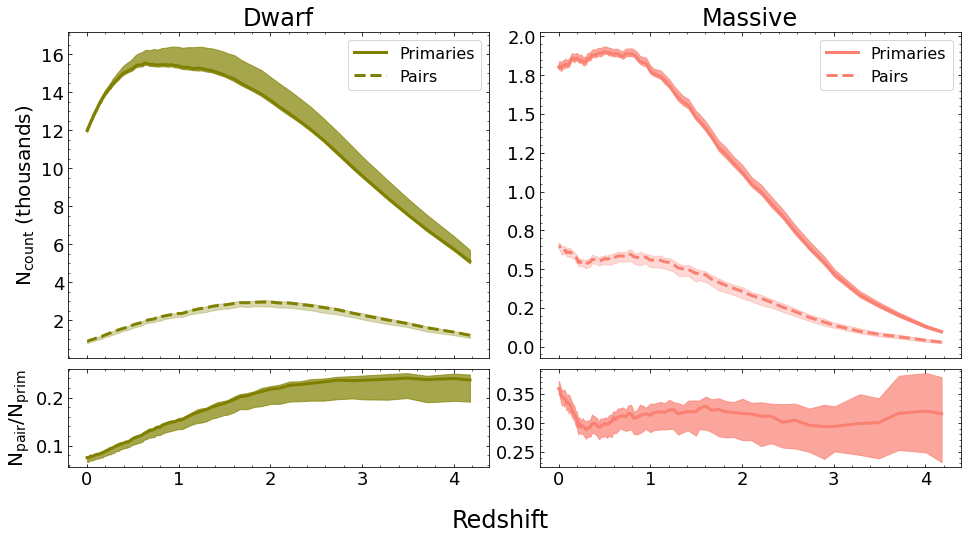

In [18]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(2, 2, figsize=(16,8), sharey=False, sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[1,0.3],'wspace': 0.12,"hspace":0.05})

axd = ax[0][0]
axm = ax[0][1]
axddiff = ax[1][0]
axmdiff = ax[1][1]
axd.set(title="Dwarf", ylabel=r"N$_{\rm count}$ (thousands)")
axm.set(title="Massive")
axddiff.set(ylabel=r"N$_{\rm pair}$/N$_{\rm prim}$")



##############
# dwarf plot #
##############
axd.plot(dwarfs['z'],dwarfs['Median Total Primaries']/1000, color=palette["dwarf"], lw=3,label="Primaries")
axd.plot(dwarfs['z'],dwarfs['Median All Pairs']/1000, color=palette["dwarf"], lw=3, linestyle="dashed",label="Pairs")

axd.fill_between(dwarfs['z'], np.array(dwarfs['Quarts Total Primaries'])[:,0]/1000, np.array(dwarfs['Quarts Total Primaries'])[:,1]/1000,color=palette["dwarf"],alpha=alphas["maj"])
axd.fill_between(dwarfs['z'], np.array(dwarfs['Quarts All Pairs'])[:,0]/1000, np.array(dwarfs['Quarts All Pairs'])[:,1]/1000,color=palette["dwarf"],alpha=alphas["min"])

################
# massive plot #
################
axm.plot(massives['z'],massives['Median Total Primaries']/1000, color=palette["massive"], lw=3, label="Primaries")
axm.plot(massives['z'],massives['Median All Pairs']/1000, color=palette["massive"], lw=3, linestyle="dashed", label="Pairs")

axm.fill_between(massives['z'], np.array(massives['Quarts Total Primaries'])[:,0]/1000, np.array(massives['Quarts Total Primaries'])[:,1]/1000,color=palette["massive"],alpha=alphas["maj"])
axm.fill_between(massives['z'], np.array(massives['Quarts All Pairs'])[:,0]/1000, np.array(massives['Quarts All Pairs'])[:,1]/1000,color=palette["massive"],alpha=alphas["min"])

##############
# dwarf diff #
##############
axddiff.plot(dwarfs['z'],dwarfs['Median Total Fraction'], color=palette["dwarf"], lw=3,label="Primaries")
axddiff.fill_between(dwarfs['z'], np.array(dwarfs['Quarts Total Fraction'])[:,0], np.array(dwarfs['Quarts Total Fraction'])[:,1],color=palette["dwarf"],alpha=alphas["maj"])

################
# massive diff #
################
axmdiff.plot(massives['z'],massives['Median Total Fraction'], color=palette["massive"], lw=3)
axmdiff.fill_between(massives['z'], np.array(massives['Quarts Total Fraction'])[:,0], np.array(massives['Quarts Total Fraction'])[:,1],color=palette["massive"],alpha=alphas["maj"])

################
# Plot styling #
################
for axx in ax[0]:
    leg = axx.legend(loc="upper right", fontsize=16)

axm.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

fig.supxlabel("Redshift")
# plt.savefig(f"../plots/paper1/counts_1000.png",bbox_inches='tight',facecolor="white")
plt.show()


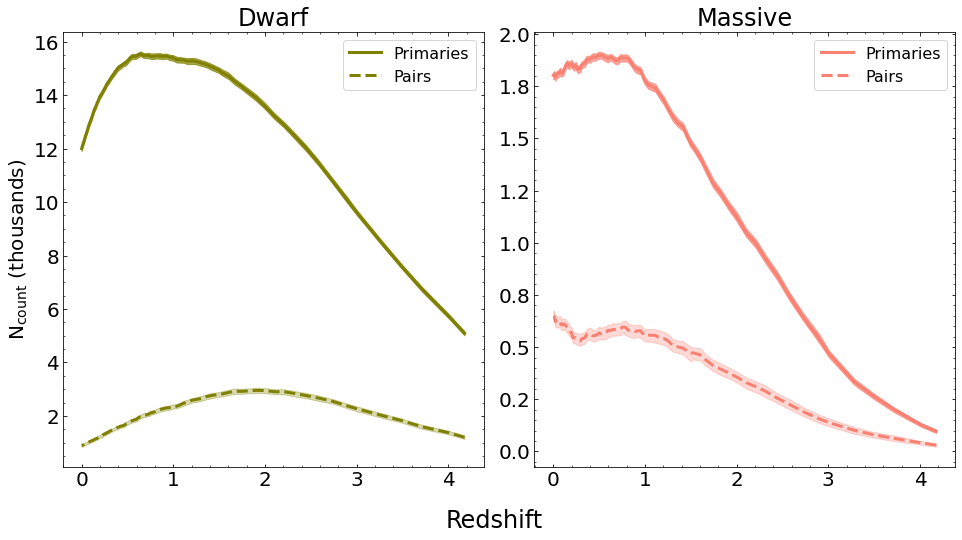

In [10]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(1, 2, figsize=(16,8), sharey=False, sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[1],'wspace': 0.12,"hspace":0.02})

axd = ax[0]
axm = ax[1]
axd.set(title="Dwarf", ylabel=r"N$_{\rm count}$ (thousands)")
axm.set(title="Massive")


####################
# dwarf plot first #
####################
    # lines
axd.plot(dwarfs['z'],dwarfs['Median Total Primaries']/1000, color=palette["dwarf"], lw=3,label="Primaries")
axd.plot(dwarfs['z'],dwarfs['Median All Pairs']/1000, color=palette["dwarf"], lw=3, linestyle = "dashed",label="Pairs")

    # fill and color labels
axd.fill_between(dwarfs['z'], np.array(dwarfs['Quarts Total Primaries'])[:,0]/1000, np.array(dwarfs['Quarts Total Primaries'])[:,1]/1000,color=palette["dwarf"],alpha=0.7)
axd.fill_between(dwarfs['z'], np.array(dwarfs['Quarts All Pairs'])[:,0]/1000, np.array(dwarfs['Quarts All Pairs'])[:,1]/1000,color=palette["dwarf"],alpha=0.3)


######################
# massive plot first #
######################
    # lines
axm.plot(massives['z'],massives['Median Total Primaries']/1000, color=palette["massive"], lw=3, label="Primaries")
axm.plot(massives['z'],massives['Median All Pairs']/1000, color=palette["massive"], lw=3, linestyle = "dashed", label="Pairs")

    # fill and color labels
axm.fill_between(massives['z'], np.array(massives['Quarts Total Primaries'])[:,0]/1000, np.array(massives['Quarts Total Primaries'])[:,1]/1000,color=palette["massive"],alpha=0.7)
axm.fill_between(massives['z'], np.array(massives['Quarts All Pairs'])[:,0]/1000, np.array(massives['Quarts All Pairs'])[:,1]/1000,color=palette["massive"],alpha=0.3)

################
# Plot styling #
################
for ax in ax:
    leg = ax.legend(loc="upper right", fontsize=16)

axm.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

fig.supxlabel("Redshift")
# plt.savefig(f"../plots/paper1/counts.png",bbox_inches='tight',facecolor="white")
plt.show()


In [12]:
def get_counts( size, reals, errorprint=False, redshiftcutoff=True):    
    snapshots = np.arange(0,100,1)
    snapshots = np.delete(snapshots, np.where(snapshots==48)[0])
    redcutoff = 4.2
        
    redshifts = []
    medone, medtwo, medtot, medmaj, medmin, medpair, medmajfrac, medminfrac, medtotfrac = [], [], [], [], [], [], [], [], []
    quartone, quarttwo, quarttot, quartmaj, quartmin, quartpair, quartmajfrac, quartminfrac, quarttotfrac = [], [], [], [], [], [], [], [], []

    for snap in snapshots:  
        singleprims, doubleprims, totalprims = [], [], []
        majorpairs, minorpairs, totalpairs = [], [], []
        majfrac, minfrac, totfrac = [], [], []
        
        try:
            pair_path = f"TNG_{snap}_{reals}.hdf5"
            pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")
            
            if np.size(pair_data) == 0:
                raise EmptyFile
                
            redshift = pair_data['Header'].attrs['Redshift']
            
            if redshiftcutoff & ( redshift > redcutoff) :
                raise SkipRedshift
                
            if (len(pair_data['pairs']["hydro"]['Group ID']) == 0):    
                raise EmptyFile
                
            unpair = pair_data["unpaired"]["hydro"]
            unpairStells = np.array(unpair["Sub1 Stellar Mass"])
            unpairGroups = np.array(unpair["Group Mass"])
            unpairReals = np.array(unpair['Realization'])
            
            pair = pair_data["pairs"]["hydro"]
            priStell = np.array(pair["Sub1 Stellar Mass"])
            secStell = np.array(pair["Sub2 Stellar Mass"])
            pairGroups = np.array(pair["Group Mass"])
            pairReals = np.array(pair["Realization"])
            seps = np.array(pair["Separation"]) 
            
            # subset masks for unpaired
            unpair_pri = get_primmask(unpairStells, size)
            unpair_group = get_groupmask(unpairGroups, size)                
            
            pair_pri = get_primmask(priStell, size)
            pair_group = get_groupmask(pairGroups, size)

            majors = (secStell/priStell > 1/4)
            minors = (secStell/priStell > 1/10) & (secStell/priStell < 1/4)
            allpairs = (majors + minors)
            pair_lowsep = (seps > 10)

            # defining combined masks 
            unpair_mask = unpair_pri & unpair_group
            primary_mask = pair_pri & pair_group
            pair_mask = pair_pri & pair_group & pair_lowsep & allpairs
                                                           
            for real in np.unique(unpairReals):                  
                # make realization masks
                unpair_real = unpairReals == real
                pair_real = pairReals == real

                # make count values for single realization
                numone = np.count_nonzero(unpair_mask & unpair_real)
                numtwo = np.count_nonzero(primary_mask & pair_real)
                numtot = numone + numtwo
                nummaj = np.count_nonzero(pair_mask & pair_real & majors)
                nummin = np.count_nonzero(pair_mask & pair_real & minors)
                numpair = np.count_nonzero(pair_mask & pair_real)
                
                if numtot == 0:
                    continue
                
                # collect count vals for all reals
                singleprims.append(numone)
                doubleprims.append(numtwo)
                totalprims.append(numtot)
                majorpairs.append(nummaj)
                minorpairs.append(nummin)
                totalpairs.append(numpair)
                majfrac.append(nummaj / numtot)
                minfrac.append(nummin / numtot)
                totfrac.append(numpair / numtot)

            # create arrays of medians and quartiles~ 
            lower, upper = 0.5, 99.5                
            redshifts.append( redshift )
            medone.append(np.median( singleprims ))
            medtwo.append(np.median( doubleprims ))
            medtot.append(np.median( totalprims ))
            medmaj.append(np.median( majorpairs ))
            medmin.append(np.median( minorpairs ))
            medpair.append(np.median( totalpairs ))
            medmajfrac.append(np.median( majfrac ))
            medminfrac.append(np.median( minfrac ))
            medtotfrac.append(np.median( totfrac ))   
            quartone.append( np.percentile( singleprims, [lower, upper]))
            quarttwo.append( np.percentile( doubleprims, [lower, upper]))
            quarttot.append( np.percentile( totalprims, [lower, upper]))
            quartmaj.append( np.percentile( majorpairs, [lower, upper]))
            quartmin.append( np.percentile( minorpairs, [lower, upper]))
            quartpair.append( np.percentile( totalpairs, [lower, upper]))
            quartmajfrac.append( np.percentile( majfrac, [lower, upper]))
            quartminfrac.append( np.percentile( minfrac, [lower, upper]))
            quarttotfrac.append( np.percentile( totfrac, [lower, upper]))
                       
        except KeyError:
            if errorprint: print(f'skipping {snap} for KeyError. Please debug')
            continue
            
        except EmptyFile:
            if errorprint: print(f"skipping {snap}, empty file")
            continue
            
        except SkipRedshift:
            if errorprint: print(f"skipping {snap}, redshift out of range")
                
    count_dictionary = {
            "z": np.array(redshifts),
            "Median Isolated Primaries": np.array(medone),
            "Median Noniso Primaries": np.array(medtwo),
            "Median Total Primaries": np.array(medtot),
            "Median Major Pairs": np.array(medmaj),
            "Median Minor Pairs": np.array(medmin),
            "Median All Pairs": np.array(medpair),
            "Median Major Fraction": np.array(medmajfrac),
            "Median Minor Fraction": np.array(medminfrac),
            "Median Total Fraction": np.array(medtotfrac),
            "Quarts Isolated Primaries": np.array(quartone),
            "Quarts Noniso Primaries": np.array(quarttwo),
            "Quarts Total Primaries": np.array(quarttot),
            "Quarts Major Pairs": np.array(quartmaj),
            "Quarts Minor Pairs": np.array(quartmin),
            "Quarts All Pairs": np.array(quartpair),
            "Quarts Major Fraction": np.array(quartmajfrac),
            "Quarts Minor Fraction": np.array(quartminfrac),
            "Quarts Total Fraction": np.array(quarttotfrac)}
            
    return count_dictionary

In [28]:
def make_countdata(reals):
    #check if files exists
    filepath = f"{paths.path_plotdata}counts.hdf5"
    if not os.path.isfile(filepath):
        print("file does not exist...")
        print("creating file")
        f = h5py.File(f"{paths.path_plotdata}counts.hdf5", 'w')
        print("file created successfully. adding header...")
        header_dict = {"1000 Reals - Quartile Range":"0.5-99.5%",
                       "Simulation":"TNG100-1 (Hydro)"}


        dset = f.create_group('/Header')
        for key in header_dict.keys():
            dset.attrs[key] = header_dict[key]
            
        print("header added successfully")
    else:
        print("file exists...")
        f = h5py.File(f"{paths.path_plotdata}counts.hdf5", 'r+')
        
        
    print("checking to see if data exists for this number of realizations")
    
    if f.get(f"{reals} Realizations") is not None:
        print("data already exists!")
        f.close()
              
    else:
        print("data does not exist...")
        print("creating data tables...")
        dwarfs = get_counts("dwarf", reals)
        print("finished creating dwarf tables")
        massives = get_counts("massive", reals)
        print("finished creating massive tables")
              
        print("creating hdf5 structure")
        for size_data, size_name in zip([dwarfs,massives],["dwarf","massive"]):
            for key, val in size_data.items():
                val = np.array(val)
                dset = f.create_dataset(f'/{reals} Realizations/{size_name}/{key}', 
                                        shape=val.shape,
                                        dtype=val.dtype)
                dset[:] = val
                
        f.close()
        print("data saved~")
    

In [32]:
make_countdata(1000)

file exists...
checking to see if data exists for this number of realizations
data does not exist...
creating data tables...
finished creating dwarf tables
finished creating massive tables
creating hdf5 structure
data saved~


In [27]:
filepath = f"{paths.path_plotdata}counts.hdf5"
os.path.isfile(filepath)

True

In [33]:
f = h5py.File(f"{paths.path_plotdata}counts.hdf5", 'r')


In [34]:
f.keys()

<KeysViewHDF5 ['10 Realizations', '100 Realizations', 'Header']>

In [37]:
f['10 Realizations']['dwarf'].keys()

<KeysViewHDF5 ['Median All Pairs', 'Median Isolated Primaries', 'Median Major Fraction', 'Median Major Pairs', 'Median Minor Fraction', 'Median Minor Pairs', 'Median Noniso Primaries', 'Median Total Fraction', 'Median Total Primaries', 'Quarts All Pairs', 'Quarts Isolated Primaries', 'Quarts Major Fraction', 'Quarts Major Pairs', 'Quarts Minor Fraction', 'Quarts Minor Pairs', 'Quarts Noniso Primaries', 'Quarts Total Fraction', 'Quarts Total Primaries', 'z']>

In [38]:
fd10 = f['10 Realizations']['dwarf']
fd100 = f['100 Realizations']['dwarf']

In [41]:
fd10['Median Total Primaries']

<HDF5 dataset "Median Total Primaries": shape (79,), type "<f8">

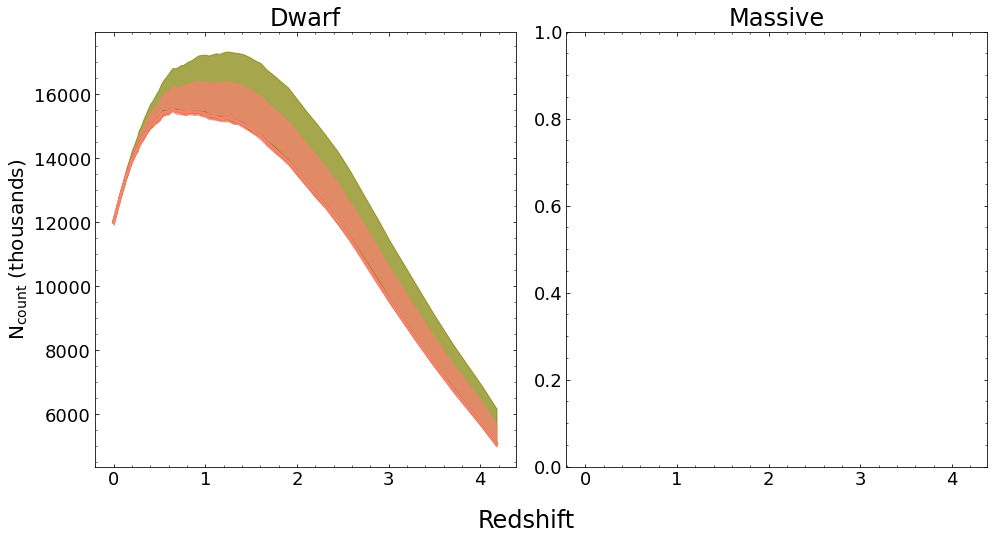

In [47]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(1, 2, figsize=(16,8), sharey=False, sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[1],'wspace': 0.12,"hspace":0.02})

axd = ax[0]
axm = ax[1]
axd.set(title="Dwarf", ylabel=r"N$_{\rm count}$ (thousands)")
axm.set(title="Massive")


####################
# dwarf plot first #
####################
    # lines
axd.plot(np.array(fd10['z']),np.array(fd10['Median Total Primaries']), color=palette["dwarf"], lw=3,label="Primaries")
axd.plot(np.array(fd100['z']),np.array(fd100['Median Total Primaries']), color=palette["massive"], lw=3,label="Pairs")

    # fill and color labels
axd.fill_between(np.array(fd10['z']), np.array(fd10['Quarts Total Primaries'])[:,0], np.array(fd10['Quarts Total Primaries'])[:,1],color=palette["dwarf"],alpha=0.7)
axd.fill_between(np.array(fd100['z']), np.array(fd100['Quarts Total Primaries'])[:,0], np.array(fd100['Quarts Total Primaries'])[:,1],color=palette["massive"],alpha=0.7)
# axd.fill_between(dwarfs['z'], np.array(dwarfs['Quarts All Pairs'])[:,0]/1000, np.array(dwarfs['Quarts All Pairs'])[:,1]/1000,color=palette["dwarf"],alpha=0.3)


######################
# massive plot first #
######################
    # lines
# axm.plot(massives['z'],massives['Median Total Primaries']/1000, color=palette["massive"], lw=3, label="Primaries")
# axm.plot(massives['z'],massives['Median All Pairs']/1000, color=palette["massive"], lw=3, linestyle = "dashed", label="Pairs")

#     # fill and color labels
# axm.fill_between(massives['z'], np.array(massives['Quarts Total Primaries'])[:,0]/1000, np.array(massives['Quarts Total Primaries'])[:,1]/1000,color=palette["massive"],alpha=0.7)
# axm.fill_between(massives['z'], np.array(massives['Quarts All Pairs'])[:,0]/1000, np.array(massives['Quarts All Pairs'])[:,1]/1000,color=palette["massive"],alpha=0.3)

################
# Plot styling #
################
# for ax in ax:
#     leg = ax.legend(loc="upper right", fontsize=16)

# axm.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

fig.supxlabel("Redshift")
# plt.savefig(f"../plots/paper1/counts.png",bbox_inches='tight',facecolor="white")
plt.show()


In [48]:
f.close()

In [45]:
paths.

SyntaxError: invalid syntax (<ipython-input-45-7a749cda5052>, line 1)

# Mass ratio distribuition

In [13]:
def get_key_snap(phys, size, key, z):
    zloc = np.where( zs['z'] == z)[0]
    sim = "TNG"
    snapshot = zs['ztng'][zloc][0] 

    pair_path = f"{sim}_{snapshot}_1000.hdf5"
    pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")
    
    pairs = pair_data["pairs"][phys]

    pri_stell = np.array(pairs["Sub1 Stellar Mass"])
    sec_stell = np.array(pairs["Sub2 Stellar Mass"])
    seps = np.array(pairs["Separation"]) 

    # masks            
    pair_pri = get_primmask(pri_stell, size)
    pair_group = get_groupmask(np.array(pairs["Group Mass"]), size)
    pair_sepcut = seps > 10
    
    majors = (sec_stell/pri_stell > 1/4)
    minors = (sec_stell/pri_stell > 1/10) & (sec_stell/pri_stell < 1/4)

    pair_mask = pair_pri & pair_group & pair_sepcut

    major_mask = pair_mask & majors
    minor_mask = pair_mask & minors

    majors = np.array(pairs[key])[major_mask]
    minors = np.array(pairs[key])[minor_mask]

    key_dict = {"major":majors, "minor":minors}
    

    return key_dict

## Subhalo Mass ratio

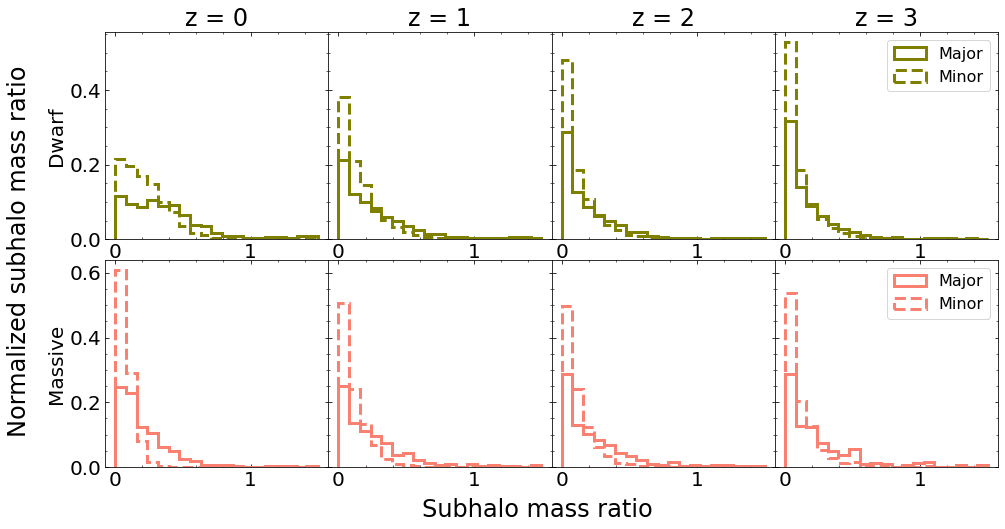

In [10]:
fig, ax = plt.subplots(2,4,figsize=(16,8),sharey="row") #sharex=False
plt.subplots_adjust(wspace=0,hspace=0.1)

for i in range(4):
    dwarf_prim = get_key_snap("hydro", "dwarf", "Sub1 Mass", i)
    dwarf_seco  = get_key_snap("hydro", "dwarf", "Sub2 Mass", i)
    massive_prim = get_key_snap("hydro", "massive", "Sub1 Mass", i)
    massive_seco  = get_key_snap("hydro", "massive", "Sub2 Mass", i)
    
#     dwarf_ratio = np.concatenate((dwarf_seco['major']/dwarf_prim['major'] , dwarf_seco['minor']/dwarf_prim['minor'])) 
#     massive_ratio = np.concatenate((massive_seco['major']/massive_prim['major'] , massive_seco['minor']/massive_prim['minor'])) 
    
    bins_d = np.linspace(0,1.5,20)
    bins_h = np.linspace(0,1.5,20)
    
    ax[0][i].set_title(f"z = {i}")

    ax[0][i].hist(dwarf_seco['major']/dwarf_prim['major'], weights=np.ones(len(dwarf_prim['major']))/len(dwarf_prim['major']),bins=bins_d, histtype="step", color=palette['dwarf'], lw=3, label='Major')
    ax[0][i].hist(dwarf_seco['minor']/dwarf_prim['minor'], weights=np.ones(len(dwarf_prim['minor']))/len(dwarf_prim['minor']),bins=bins_d, histtype="step", color=palette['dwarf'], linestyle="dashed", lw=3, label='Minor')

    ax[1][i].hist(massive_seco['major']/massive_prim['major'], weights=np.ones(len(massive_prim['major']))/len(massive_prim['major']),bins=bins_d, histtype="step", color=palette['massive'], lw=3, label='Major')
    ax[1][i].hist(massive_seco['minor']/massive_prim['minor'], weights=np.ones(len(massive_prim['minor']))/len(massive_prim['minor']),bins=bins_d, histtype="step", color=palette['massive'], linestyle="dashed", lw=3, label='Minor')

for xx in [ax[0][3],ax[1][3]]:
    leg = xx.legend(loc='upper right',fontsize=16)

fig.supxlabel(r"Subhalo mass ratio",y=0.03)
ax[0][0].set_ylabel("Dwarf")
ax[1][0].set_ylabel("Massive")
fig.supylabel("Normalized subhalo mass ratio",x=0.040)

# plt.savefig(f"../plots/paper1/subhalomass_distributions.png",bbox_inches='tight',facecolor="white")
plt.show()

In [11]:
ratmaj = dwarf_seco["major"]/dwarf_prim["major"]
ratmin = dwarf_seco["minor"]/dwarf_prim["minor"]

print("fraction of major dwarf pairs with M2 > M1",len(np.where(ratmaj > 1)[0])/len(ratmaj))
print("fraction of minor dwarf pairs with M2 > M1",len(np.where(ratmin > 1)[0])/len(ratmin))

print("fraction of major dwarf pairs with M2 > 10 M1",len(np.where(ratmaj > 10)[0])/len(ratmaj))
print("fraction of minor dwarf pairs with M2 > 10 M1",len(np.where(ratmin > 10)[0])/len(ratmin))

fraction of major dwarf pairs with M2 > M1 0.2723515938934035
fraction of minor dwarf pairs with M2 > M1 0.06793067995516983
fraction of major dwarf pairs with M2 > 10 M1 0.11107126264396391
fraction of minor dwarf pairs with M2 > 10 M1 0.027694673175069236


In [12]:
ratmaj = massive_seco["major"]/massive_prim["major"]
ratmin = massive_seco["minor"]/massive_prim["minor"]

print("fraction of major massive pairs with M2 > M1",len(np.where(ratmaj > 1)[0])/len(ratmaj))
print("fraction of minor massive pairs with M2 > M1",len(np.where(ratmin > 1)[0])/len(ratmin))

print("fraction of major massive pairs with M2 > 10 M1",len(np.where(ratmaj > 10)[0])/len(ratmaj))
print("fraction of minor massive pairs with M2 > 10 M1",len(np.where(ratmin > 10)[0])/len(ratmin))

fraction of major massive pairs with M2 > M1 0.19492455418381344
fraction of minor massive pairs with M2 > M1 0.016730826177080247
fraction of major massive pairs with M2 > 10 M1 0.05747599451303155
fraction of minor massive pairs with M2 > 10 M1 0.00414569144210838


## Stellar mass ratio

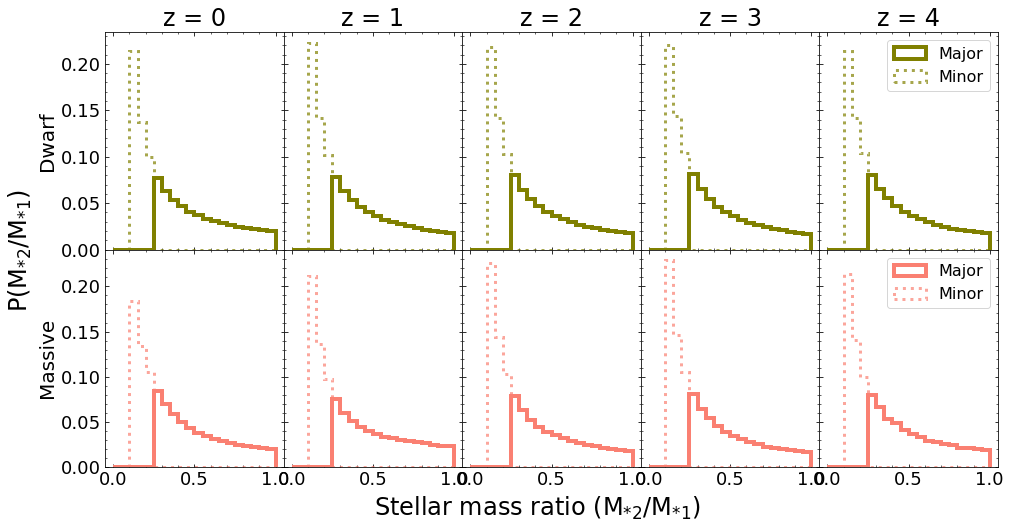

In [14]:
fig, ax = plt.subplots(2,5,figsize=(16,8),sharey="row",sharex=True)
# plt.subplots_adjust(wspace=0.01,hspace=0.01)
plt.subplots_adjust(wspace=0,hspace=0)

for i in range(5):
    dwarf = get_key_snap("hydro", "dwarf", "Stellar Mass Ratio", i)
    massive = get_key_snap("hydro", "massive", "Stellar Mass Ratio", i)
    
    bins_d = np.arange(0,1.05,0.05)
    bins_h = np.arange(0,1.05,0.05)
    
    ax[0][i].set_title(f"z = {i}")

    ax[0][i].hist(dwarf['major'],bins=bins_d, weights=np.ones(len(dwarf['major']))/ (len(dwarf['major']) + len(dwarf['minor'])), histtype="step", color=palette['dwarf'], lw=4, label='Major')
    ax[0][i].hist(dwarf['minor'],bins=bins_d, weights=np.ones(len(dwarf['minor']))/ (len(dwarf['major']) + len(dwarf['minor'])), histtype="step", color=palette['dwarf'], lw=3, linestyle='dotted', alpha=0.7, label='Minor')

    ax[1][i].hist(massive['major'],bins=bins_d, weights=np.ones(len(massive['major']))/(len(massive['major']) + len(massive['minor'])), histtype="step", color=palette['massive'], lw=4, label='Major')
    ax[1][i].hist(massive['minor'],bins=bins_d, weights=np.ones(len(massive['minor']))/(len(massive['major']) + len(massive['minor'])), histtype="step", color=palette['massive'], lw=3, linestyle='dotted', alpha=0.7, label='Minor')

for xx in [ax[0][-1],ax[1][-1]]:
    leg = xx.legend(loc='upper right',fontsize=16)
    
for i in range(5):
    ax[1][i].tick_params(axis='x', which='major', labelsize=18)
for i in range(2):
    ax[i][0].tick_params(axis='y', which='major', labelsize=18)

fig.supxlabel(r"Stellar mass ratio ($\rm M_{*2}/M_{*1}$)",y=0.03)
ax[0][0].set_ylabel("Dwarf")
ax[1][0].set_ylabel("Massive")    
fig.supylabel(r"P($\rm M_{*2}/M_{*1}$)",x=0.040)

plt.savefig(f"../plots/paper1/stellarmass_distribution_1000.png",bbox_inches='tight',facecolor="white")
plt.show()

In [15]:
for i in range(5):
    dw = get_key_snap("hydro", "dwarf", "Stellar Mass Ratio", i)
    ma = get_key_snap("hydro", "massive", "Stellar Mass Ratio", i)
    
    print(f"Dwarf fraction of major pairs at z={i} is ",len(dw["major"])/(len(dw["major"])+len(dw["minor"])))
    print(f"Massive fraction of major pairs at z={i} is ",len(ma["major"])/(len(ma["major"])+len(ma["minor"])))

Dwarf fraction of major pairs at z=0 is  0.5487508868056702
Massive fraction of major pairs at z=0 is  0.5761889695725652
Dwarf fraction of major pairs at z=1 is  0.5345015342496425
Massive fraction of major pairs at z=1 is  0.5553659168243326
Dwarf fraction of major pairs at z=2 is  0.5374399846588405
Massive fraction of major pairs at z=2 is  0.5271005717657306
Dwarf fraction of major pairs at z=3 is  0.5321114981654801
Massive fraction of major pairs at z=3 is  0.5188564081449859
Dwarf fraction of major pairs at z=4 is  0.5410956608903174
Massive fraction of major pairs at z=4 is  0.545143605666602


# Pair fraction

In [16]:
def get_pairratio(errorprint=False, redshiftcutoff=True):    
    snapshots = np.arange(0,100,1)
    snapshots = np.delete(snapshots, np.where(snapshots==48)[0])
    redcutoff = 4.2
        
    redshifts = []
    medfrac_majdw, medfrac_mindw, medfrac_majma, medfrac_minma  = [], [], [], []
    quartfrac_majdw, quartfrac_mindw, quartfrac_majma, quartfrac_minma = [], [], [], []
    medfrac_majdiff, medfrac_mindiff, quartfrac_majdiff, quartfrac_mindiff  = [], [], [], []

    for snap in snapshots:  
        frac_majdw, frac_mindw, frac_majma, frac_minma = [], [], [], []
        frac_majdiff, frac_mindiff = [], []
        
        try:
            pair_path = f"TNG_{snap}_1000.hdf5"
            pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")
            
            if np.size(pair_data) == 0:
                raise EmptyFile
                
            redshift = pair_data['Header'].attrs['Redshift']
            
            if redshiftcutoff & ( redshift > redcutoff) :
                raise SkipRedshift
                
            if (len(pair_data['pairs']["hydro"]['Group ID']) == 0):    
                raise EmptyFile
            
            unpair = pair_data["unpaired"]["hydro"]
            unpairStells = np.array(unpair["Sub1 Stellar Mass"])
            unpairGroups = np.array(unpair["Group Mass"])
            unpairReals = np.array(unpair['Realization'])
            
            pair = pair_data["pairs"]["hydro"]
            priStell = np.array(pair["Sub1 Stellar Mass"])
            secStell = np.array(pair["Sub2 Stellar Mass"])
            pairGroups = np.array(pair["Group Mass"])
            pairReals = np.array(pair["Realization"])
            seps = np.array(pair["Separation"]) 
            
            # subset masks for unpaired
            majors = (secStell/priStell > 1/4)
            minors = (secStell/priStell > 1/10) & (secStell/priStell < 1/4)
            allpairs = (majors + minors)
            pair_lowsep = (seps > 10)
            
            ## dwarfs
            unpair_pri_dwarf = get_primmask(unpairStells, "dwarf")
            unpair_group_dwarf = get_groupmask(unpairGroups, "dwarf")                
            
            pair_pri_dwarf = get_primmask(priStell, "dwarf")
            pair_group_dwarf = get_groupmask(pairGroups, "dwarf")
            
                # defining combined masks 
            unpair_mask_dwarf = unpair_pri_dwarf & unpair_group_dwarf
            primary_mask_dwarf = pair_pri_dwarf & pair_group_dwarf
            pair_mask_dwarf = pair_pri_dwarf & pair_group_dwarf & pair_lowsep & allpairs
            
            ## massive
            unpair_pri_massive = get_primmask(unpairStells, "massive")
            unpair_group_massive = get_groupmask(unpairGroups, "massive")                
            
            pair_pri_massive = get_primmask(priStell, "massive")
            pair_group_massive = get_groupmask(pairGroups, "massive")

                # defining combined masks 
            unpair_mask_massive = unpair_pri_massive & unpair_group_massive
            primary_mask_massive = pair_pri_massive & pair_group_massive
            pair_mask_massive = pair_pri_massive & pair_group_massive & pair_lowsep & allpairs
                                                          
            for real in np.unique(unpairReals):                  
                # make realization masks
                unpair_real = unpairReals == real
                pair_real = pairReals == real

                # make count values for single realization
                numone_dwarf = np.count_nonzero(unpair_mask_dwarf & unpair_real)
                numtwo_dwarf = np.count_nonzero(primary_mask_dwarf & pair_real)
                numtot_dwarf = numone_dwarf + numtwo_dwarf
                nummaj_dwarf = np.count_nonzero(pair_mask_dwarf & pair_real & majors)
                nummin_dwarf = np.count_nonzero(pair_mask_dwarf & pair_real & minors)
                numpair_dwarf = np.count_nonzero(pair_mask_dwarf & pair_real)
                
                # make count values for single realization
                numone_massive = np.count_nonzero(unpair_mask_massive & unpair_real)
                numtwo_massive = np.count_nonzero(primary_mask_massive & pair_real)
                numtot_massive = numone_massive + numtwo_massive
                nummaj_massive = np.count_nonzero(pair_mask_massive & pair_real & majors)
                nummin_massive = np.count_nonzero(pair_mask_massive & pair_real & minors)
                numpair_massive = np.count_nonzero(pair_mask_massive & pair_real)
                
                if (numtot_dwarf == 0) or (numtot_massive == 0):
                    continue
                    
                # collect vals for all reals
                frac_majdw.append( nummaj_dwarf/numtot_dwarf ) 
                frac_mindw.append( nummin_dwarf/numtot_dwarf ) 
                frac_majma.append( nummaj_massive/numtot_massive ) 
                frac_minma.append( nummin_massive/numtot_massive ) 
                frac_majdiff.append( (nummaj_massive/numtot_massive) - (nummaj_dwarf/numtot_dwarf) ) 
                frac_mindiff.append( (nummin_massive/numtot_massive) - (nummaj_dwarf/numtot_dwarf) ) 
                    
            # create arrays of medians and quartiles~ 
            lower, upper = 0.5, 99.5                
            redshifts.append( redshift )
            
            medfrac_majdw.append( np.median( frac_majdw ) )
            medfrac_mindw.append( np.median( frac_mindw ) )
            medfrac_majma.append( np.median( frac_majma ) )
            medfrac_minma.append( np.median( frac_minma ) )
            medfrac_majdiff.append( np.median( frac_majdiff ) )
            medfrac_mindiff.append( np.median( frac_mindiff ) )
            
            quartfrac_majdw.append( np.percentile( frac_majdw, [lower,upper] ) )
            quartfrac_mindw.append( np.percentile( frac_mindw, [lower,upper] ) )
            quartfrac_majma.append( np.percentile( frac_majma, [lower,upper] ) )
            quartfrac_minma.append( np.percentile( frac_minma, [lower,upper] ) )
            quartfrac_majdiff.append( np.percentile( frac_majdiff, [lower,upper] ) )
            quartfrac_mindiff.append( np.percentile( frac_mindiff, [lower,upper] ) )

                                   
        except KeyError:
            if errorprint: print(f'skipping {snap} for KeyError. Please debug')
            continue
            
        except EmptyFile:
            if errorprint: print(f"skipping {snap}, empty file")
            continue
            
        except SkipRedshift:
            if errorprint: print(f"skipping {snap}, redshift out of range")
                
    count_dictionary = {
            "z": np.array(redshifts),
        
            "Median Major Dwarf": np.array(medfrac_majdw),
            "Median Minor Dwarf": np.array(medfrac_mindw),
            "Median Major Massive": np.array(medfrac_majma),
            "Median Minor Massive": np.array(medfrac_minma),
            "Median Major Difference": np.array(medfrac_majdiff),
            "Median Minor Difference": np.array(medfrac_mindiff),
        
            "Quartile Major Dwarf": np.array(quartfrac_majdw),
            "Quartile Minor Dwarf": np.array(quartfrac_mindw),
            "Quartile Major Massive": np.array(quartfrac_majma),
            "Quartile Minor Massive": np.array(quartfrac_minma),
            "Quartile Major Difference": np.array(quartfrac_majdiff),
            "Quartile Minor Difference": np.array(quartfrac_mindiff) }
    
    return count_dictionary


In [17]:
ratios = get_pairratio()

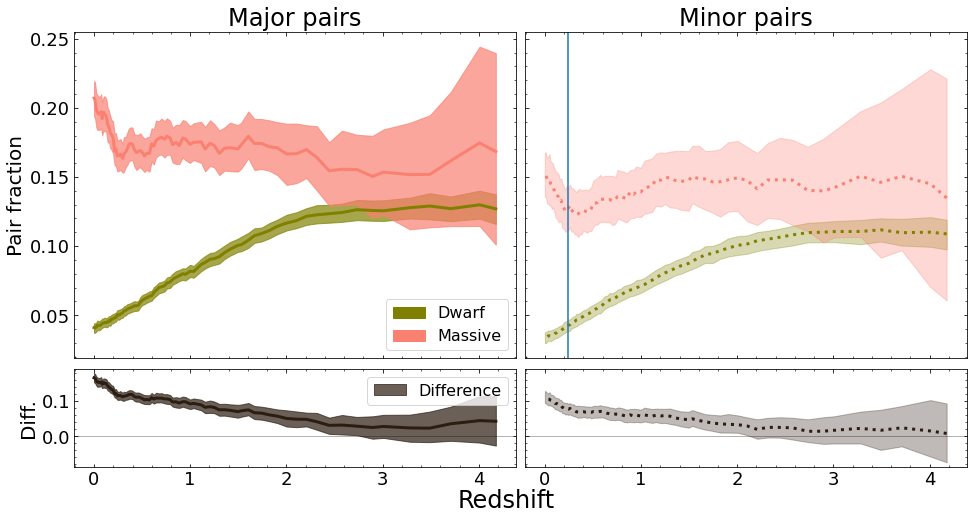

In [45]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(2, 2, figsize=(16,8), sharey="row", sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[1,0.3],'wspace': 0.02,"hspace":0.05})

ax_d = ax[0][0]
ax_m = ax[0][1]
ax_ddiff = ax[1][0]
ax_mdiff = ax[1][1]
ax_d.set(title="Major pairs", ylabel="Pair fraction")
ax_m.set(title="Minor pairs")
ax_ddiff.set(ylabel="Diff.")

al = 0.7

#############
# dwarf #
#############
# ax_d.plot(dwarfs['z'],dwarfs['Median Major Fraction'], color=palette["dwarf"], lw=3)
# ax_d.fill_between(dwarfs['z'], np.array(dwarfs['Quarts Major Fraction'])[:,0], np.array(dwarfs['Quarts Major Fraction'])[:,1],color=palette["dwarf"],alpha=al, label="Dwarf")

ax_d.plot(ratios['z'],ratios['Median Major Dwarf'], color=palette["dwarf"], lw=3)
ax_d.fill_between(ratios['z'], np.array(ratios['Quartile Major Dwarf'])[:,0], np.array(ratios['Quartile Major Dwarf'])[:,1],color=palette["dwarf"],alpha=al, label="Dwarf")


ax_d.plot(ratios['z'],ratios['Median Major Massive'], color=palette["massive"], lw=3)
ax_d.fill_between(ratios['z'], np.array(ratios['Quartile Major Massive'])[:,0], np.array(ratios['Quartile Major Massive'])[:,1],color=palette["massive"],alpha=al, label="Massive")


###########
# massive #
###########
ax_m.plot(ratios['z'],ratios['Median Minor Dwarf'], color=palette["dwarf"], lw=3, linestyle="dotted")
ax_m.fill_between(ratios['z'], np.array(ratios['Quartile Minor Dwarf'])[:,0], np.array(ratios['Quartile Minor Dwarf'])[:,1],color=palette["dwarf"],alpha=alphas["min"], label="Dwarf")


ax_m.plot(ratios['z'],ratios['Median Minor Massive'], color=palette["massive"], lw=3, linestyle="dotted")
ax_m.fill_between(ratios['z'], np.array(ratios['Quartile Minor Massive'])[:,0], np.array(ratios['Quartile Minor Massive'])[:,1],color=palette["massive"],alpha=alphas["min"], label="Massive")



### 
ax_ddiff.plot(ratios['z'],ratios['Median Major Difference'], color="#2C1D11", lw=3)
ax_ddiff.fill_between(ratios['z'], np.array(ratios['Quartile Major Difference'])[:,0], np.array(ratios['Quartile Major Difference'])[:,1],color="#2C1D11",alpha=al, label="Difference")

ax_mdiff.plot(ratios['z'],ratios['Median Minor Difference'], color="#2C1D11", lw=3,linestyle="dotted")
ax_mdiff.fill_between(ratios['z'], np.array(ratios['Quartile Minor Difference'])[:,0], np.array(ratios['Quartile Minor Difference'])[:,1],color="#2C1D11",alpha=0.3)

ax_ddiff.axhline(0,color="black",lw=1,alpha=0.3)
ax_mdiff.axhline(0,color="black",lw=1,alpha=0.3)
# ax_m.axvline(ratios['z'][-19])

#############
#############
for ax in [ax_d]:
    leg = ax.legend(loc='lower right',fontsize=16)

    for lh in leg.legendHandles: 
        lh.set_alpha(1)
ax_ddiff.legend(loc="upper right",fontsize=16)        
# ax_d.set_xlim(0,4)
fig.supxlabel("Redshift",y=0.045)
# plt.savefig(f"../plots/paper1/pairratio_1000.png",bbox_inches='tight',facecolor="white")
plt.show()


In [55]:
f1 = ratios['Median Major Difference'][-1]
f2 = ratios['Median Minor Difference'][-1]



print("major difference of", f1)
print("minor difference of", f2)

major difference of 0.16621991287282442
minor difference of 0.11125701266248239


In [54]:
z1 = ratios['z'][5]
z2 = ratios['z'][-1]
f1 = ratios['Median Minor Dwarf'][5]
f2 = ratios['Median Minor Dwarf'][-1]



print("At z=%0.1f,"%z1,"fraction of", f1)
print("At z=%0.1f,"%z2,"fraction of", f2)
print((f1-f2)/f1)




At z=3.0, fraction of 0.11050591808945219
At z=0.0, fraction of 0.03360226233053314
0.6959234137728911


# Sep and Vel evolution

In [6]:
def get_key(sim, phys, size, key, sepcut, errorprint=False, redshiftcutoff=True): 
    if sim == "Illustris":
        snapshots = np.arange(0,136,1)
        snapshots = np.delete(snapshots, np.where(snapshots==113)[0])
        redcutoff = 3.8
    elif sim == "TNG":
        snapshots = np.arange(0,100,1)
        snapshots = np.delete(snapshots, np.where(snapshots==48)[0])
        redcutoff = 4.2
        
    redshifts = []  
    med_pairs, med_major, med_minor, med_diff = [], [], [], []
    quart_pairs, quart_major, quart_minor, quart_diff = [], [], [], []
            
    for snap in snapshots:  
        try:
            pair_path = f"{sim}_{snap}_1000.hdf5"
            pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")
            
            if np.size(pair_data) == 0:
                raise EmptyFile
                
            redshift = pair_data['Header'].attrs['Redshift']
            
            if redshiftcutoff & ( redshift > redcutoff) :
                raise SkipRedshift
                
            if (len(pair_data['pairs'][phys]['Group ID']) == 0):    
                raise EmptyFile
                
            pair = pair_data["pairs"][phys]
            priStell = np.array(pair["Sub1 Stellar Mass"])
            secStell = np.array(pair["Sub2 Stellar Mass"])
            pairGroups = np.array(pair["Group Mass"])
            pairGrRads = np.array(pair["Group Radius"])
            pairReals = np.array(pair["Realization"])
            seps = np.array(pair["Separation"]) 
            keydat = np.array(pair[key])
            
            # subset masks for unpaired
            pair_pri = get_primmask(priStell, size)
            pair_group = get_groupmask(pairGroups, size)

            majors = (secStell/priStell > 1/4)
            minors = (secStell/priStell > 1/10) & (secStell/priStell < 1/4)
            pair_lowsep = (seps > 10)

            # defining combined masks 
            pair_mask = pair_pri & pair_group & pair_lowsep
        
            if sepcut == "low":
                sep_mask = seps < 0.5*pairGrRads
                pair_mask = pair_mask & sep_mask
            elif sepcut == "high":
                sep_mask = seps > 0.5*pairGrRads
                pair_mask = pair_mask & sep_mask
                               
            pair_per_real = []
            major_per_real = []
            minor_per_real = []
            diff_per_real = []
                
            realizations = np.unique( pairReals )

            for real in realizations:
                pair_real = pairReals == real

                pair_mask_real = pair_mask & pair_real & (majors | minors)
                major_mask_real = pair_mask_real & majors
                minor_mask_real = pair_mask_real & minors

                pair_xx = np.median( keydat[pair_mask_real] )
                major_xx = np.median( keydat[major_mask_real] )
                minor_xx = np.median( keydat[minor_mask_real] )
                diff_xx = major_xx-minor_xx

                pair_per_real.append( pair_xx )
                major_per_real.append( major_xx )
                minor_per_real.append( minor_xx )
                diff_per_real.append( diff_xx )
            
            med_pairs_snap = np.median(pair_per_real)
            med_major_snap = np.median(major_per_real)
            med_minor_snap = np.median(minor_per_real)
            med_diff_snap = np.median(diff_per_real)
            quart_pairs_snap = np.percentile( pair_per_real,[16,84] ) 
            quart_major_snap = np.percentile( major_per_real,[16,84] ) 
            quart_minor_snap = np.percentile( minor_per_real,[16,84] ) 
            quart_diff_snap = np.percentile( diff_per_real,[16,84] ) 
                
            redshifts.append( redshift )
            med_pairs.append( med_pairs_snap )
            med_major.append( med_major_snap )
            med_minor.append( med_minor_snap )
            med_diff.append( med_diff_snap )

            quart_pairs.append( quart_pairs_snap )
            quart_major.append( quart_major_snap )
            quart_minor.append( quart_minor_snap )
            quart_diff.append( quart_diff_snap )

        except KeyError:
            if errorprint: print(f'skipping {snap} for KeyError. Please debug')
            continue
            
        except EmptyFile:
            if errorprint: print(f"skipping {snap}, empty file")
            continue
            
        except SkipRedshift:
            if errorprint: print(f"skipping {snap}, redshift out of range")
                
                
    sep_dictionary = {"z":np.array(redshifts),
                        "All Median": np.array(med_pairs),
                        "Major Median": np.array(med_major),
                        "Minor Median":np.array(med_minor),
                        "Difference Median":np.array(med_diff),
                        "All Quarts":np.array(quart_pairs),
                        "Major Quarts":np.array(quart_major),
                        "Minor Quarts":np.array(quart_minor),
                        "Difference Quarts":np.array(quart_diff) }
    
    return sep_dictionary



In [7]:
# function to make major+minor sep plots
d_seps = get_key("TNG", "hydro", "dwarf", "Separation", None)
d_vels = get_key("TNG", "hydro", "dwarf", "RelVel", None)
print("done with dwarf")

m_seps = get_key("TNG", "hydro", "massive", "Separation", None)
m_vels = get_key("TNG", "hydro", "massive", "RelVel", None)
print("done with massive")


done with dwarf
done with massive


## Separations

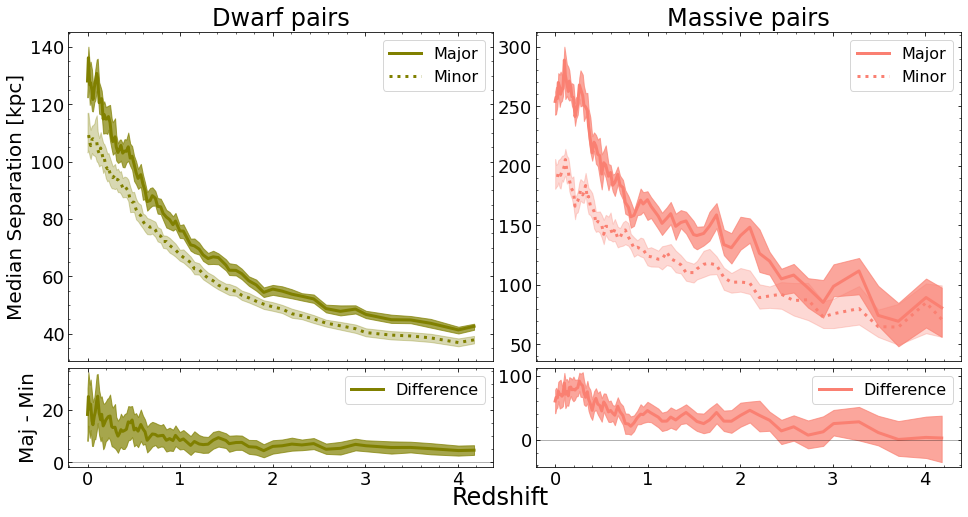

In [18]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(2, 2, figsize=(16,8), sharey=False, sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[1,0.3],'wspace': 0.1,"hspace":0.03})

ax_d = ax[0][0]
ax_m = ax[0][1]
ax_ddiff = ax[1][0]
ax_mdiff = ax[1][1]

ax_d.set(title="Dwarf pairs", ylabel="Median Separation [kpc]")
ax_m.set(title="Massive pairs")
ax_ddiff.set(ylabel="Maj - Min")

al = 0.7

#############
# dwarf #
#############
ax_d.plot(d_seps['z'],d_seps['Major Median'], color=palette["dwarf"], lw=3, label="Major")
ax_d.plot(d_seps['z'],d_seps['Minor Median'], color=palette["dwarf"], lw=3, linestyle="dotted", label="Minor")

ax_d.fill_between(d_seps['z'], np.array(d_seps['Major Quarts'])[:,0], np.array(d_seps['Major Quarts'])[:,1],color=palette["dwarf"], alpha=alphas["maj"])
ax_d.fill_between(d_seps['z'], np.array(d_seps['Minor Quarts'])[:,0], np.array(d_seps['Minor Quarts'])[:,1],color=palette["dwarf"], alpha=alphas["min"])


#############
# massive #
#############
ax_m.plot(m_seps['z'],m_seps['Major Median'], color=palette["massive"], lw=3, label="Major")
ax_m.plot(m_seps['z'],m_seps['Minor Median'], color=palette["massive"], lw=3, linestyle="dotted", label="Minor")

ax_m.fill_between(m_seps['z'], np.array(m_seps['Major Quarts'])[:,0], np.array(m_seps['Major Quarts'])[:,1],color=palette["massive"],alpha=alphas["maj"])
ax_m.fill_between(m_seps['z'], np.array(m_seps['Minor Quarts'])[:,0], np.array(m_seps['Minor Quarts'])[:,1],color=palette["massive"],alpha=alphas["min"])


####################
# dwarf difference #
####################
# axmaj_d.plot(tngd_d['z'],tngd_d['Major Median'], color=palette["Illustris dark"], lw=3)
ax_ddiff.plot(d_seps['z'],d_seps['Difference Median'], color=palette["dwarf"], lw=3, label="Difference")
ax_ddiff.fill_between(d_seps['z'], np.array(d_seps['Difference Quarts'])[:,0], np.array(d_seps['Difference Quarts'])[:,1],color=palette["dwarf"], alpha=alphas["maj"])


######################
# massive difference #
######################
ax_mdiff.plot(m_seps['z'],m_seps['Difference Median'], color=palette["massive"], lw=3, label="Difference")
ax_mdiff.fill_between(m_seps['z'], np.array(m_seps['Difference Quarts'])[:,0], np.array(m_seps['Difference Quarts'])[:,1],color=palette["massive"],alpha=alphas["maj"])

ax_ddiff.axhline(0,color="black",lw=1,alpha=0.3)
ax_mdiff.axhline(0,color="black",lw=1,alpha=0.3)

#############
#############
for ax in [ax_d,ax_m,ax_mdiff, ax_ddiff]:
    leg = ax.legend(loc='upper right',fontsize=16)

#     for lh in leg.legendHandles: 
#         lh.set_alpha(1)
              
fig.supxlabel("Redshift",y=0.05)
plt.savefig(f"../plots/paper1/separation_1000.png",bbox_inches='tight',facecolor="white")
plt.show()


In [32]:
m_seps['z'][29]

0.9972942257819404

In [37]:
max(m_seps['Minor Median'][-20:-1])

205.21323487903436

In [33]:
print('major dwarf: z=4 is ',d_seps['Major Median'][0], "z=0 is",d_seps['Major Median'][-1])
print('minor dwarf: z=4 is ',d_seps['Minor Median'][0], "z=0 is",d_seps['Minor Median'][-1])
print('major massive z=4 is ',m_seps['Major Median'][0], "z=0 is",m_seps['Major Median'][-1])
print('minor massive z=4 is ',m_seps['Minor Median'][0], "z=0 is",m_seps['Minor Median'][-1])

print('major massive z=1 is ',m_seps['Major Median'][29])
print('minor massive z=1 is ',m_seps['Minor Median'][29])

major dwarf: z=4 is  42.50555195342244 z=0 is 128.09492612218634
minor dwarf: z=4 is  37.77784094200939 z=0 is 109.08681827882475
major massive z=4 is  80.84917951519516 z=0 is 253.9963804859468
minor massive z=4 is  71.15711597454981 z=0 is 190.76623878152412
major massive z=1 is  171.49964321690095
minor massive z=1 is  124.0895054671989


## Velocities

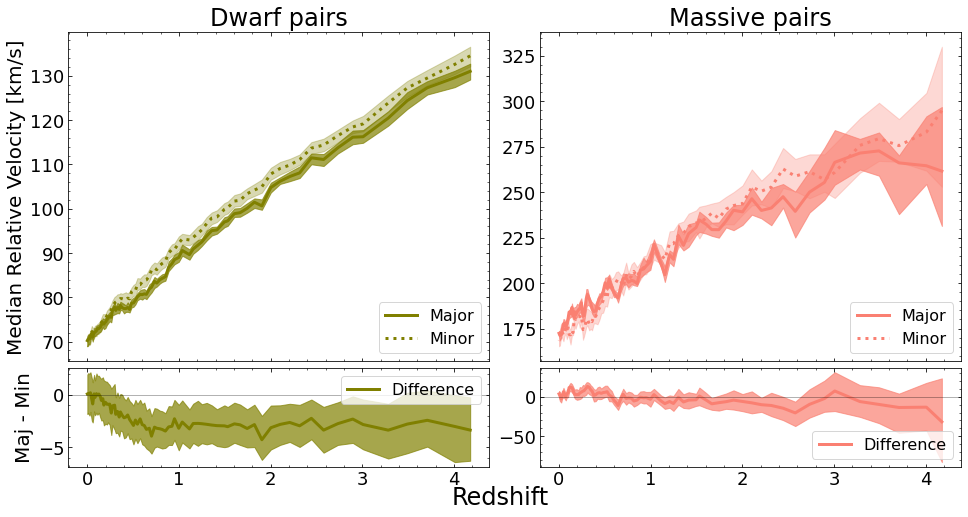

In [17]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(2, 2, figsize=(16,8), sharey=False, sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[1,0.3],'wspace': 0.12,"hspace":0.03})

ax_d = ax[0][0]
ax_m = ax[0][1]
ax_ddiff = ax[1][0]
ax_mdiff = ax[1][1]

ax_d.set(title="Dwarf pairs", ylabel="Median Relative Velocity [km/s]")
ax_m.set(title="Massive pairs")
ax_ddiff.set(ylabel="Maj - Min")

#############
# dwarf #
#############
ax_d.plot(d_vels['z'],d_vels['Major Median'], color=palette["dwarf"], lw=3, label="Major")
ax_d.plot(d_vels['z'],d_vels['Minor Median'], color=palette["dwarf"], lw=3,linestyle="dotted", label="Minor")

ax_d.fill_between(d_vels['z'], np.array(d_vels['Major Quarts'])[:,0], np.array(d_vels['Major Quarts'])[:,1], color=palette["dwarf"], alpha=alphas["maj"])
ax_d.fill_between(d_vels['z'], np.array(d_vels['Minor Quarts'])[:,0], np.array(d_vels['Minor Quarts'])[:,1], color=palette["dwarf"], alpha=alphas["min"])

#############
# massive #
#############
ax_m.plot(m_vels['z'],m_vels['Major Median'], color=palette["massive"], lw=3, label="Major")
ax_m.plot(m_vels['z'],m_vels['Minor Median'], color=palette["massive"], lw=3, linestyle="dotted", label="Minor")

ax_m.fill_between(m_vels['z'], np.array(m_vels['Major Quarts'])[:,0], np.array(m_vels['Major Quarts'])[:,1], color=palette["massive"], alpha=alphas["maj"])
ax_m.fill_between(m_vels['z'], np.array(m_vels['Minor Quarts'])[:,0], np.array(m_vels['Minor Quarts'])[:,1], color=palette["massive"], alpha=alphas["min"])

####################
# dwarf difference #
####################
# axmaj_d.plot(tngd_d['z'],tngd_d['Major Median'], color=palette["Illustris dark"], lw=3)
ax_ddiff.plot(d_vels['z'],d_vels['Difference Median'], color=palette["dwarf"], lw=3, label="Difference")
ax_ddiff.fill_between(d_vels['z'], np.array(d_vels['Difference Quarts'])[:,0], np.array(d_vels['Difference Quarts'])[:,1],color=palette["dwarf"], alpha=alphas["maj"])

######################
# massive difference #
######################
ax_mdiff.plot(m_vels['z'],m_vels['Difference Median'], color=palette["massive"], lw=3, label="Difference")
ax_mdiff.fill_between(m_vels['z'], np.array(m_vels['Difference Quarts'])[:,0], np.array(m_vels['Difference Quarts'])[:,1],color=palette["massive"],alpha=alphas["maj"])

ax_ddiff.axhline(0,color="black",lw=1,alpha=0.3)
ax_mdiff.axhline(0,color="black",lw=1,alpha=0.3)

#############
#############
for axx in [ax_d,ax_m]:
    leg = axx.legend(loc='lower right',fontsize=16)
ax_ddiff.legend(loc='upper right',fontsize=16)
ax_mdiff.legend(loc='lower right',fontsize=16)
    
fig.supxlabel("Redshift",y=0.05)
plt.savefig(f"../plots/paper1/velocity_1000.png",bbox_inches='tight',facecolor="white")
plt.show()


In [22]:
print('major dwarf: z=4 is ',d_vels['Major Median'][0], "z=0 is",d_vels['Major Median'][-1])
print('minor dwarf: z=4 is ',d_vels['Minor Median'][0], "z=0 is",d_vels['Minor Median'][-1])
print('major massive z=4 is ',m_vels['Major Median'][0], "z=0 is",m_vels['Major Median'][-1])
print('minor massive z=4 is ',m_vels['Minor Median'][0], "z=0 is",m_vels['Minor Median'][-1])

major dwarf: z=4 is  131.03819120771948 z=0 is 70.24218435860143
minor dwarf: z=4 is  134.5313617744486 z=0 is 70.0476092193611
major massive z=4 is  261.55672707377937 z=0 is 172.39239496968645
minor massive z=4 is  294.8468169401724 z=0 is 168.27376450727212


# Scaled Sep and Vel Evolution

In [128]:
def get_scaledkey(key, errorprint=False, redshiftcutoff=True):    
    snapshots = np.arange(0,100,1)
    snapshots = np.delete(snapshots, np.where(snapshots==48)[0])
    redcutoff = 4.2
        
    redshifts = []  
    med_majdw, med_mindw, med_majma, med_minma, med_majdiff, med_mindiff = [], [], [], [], [], []
    quart_majdw, quart_mindw, quart_majma, quart_minma, quart_majdiff, quart_mindiff = [], [], [], [], [], []
            
    for snap in snapshots:  
        try:
            pair_path = f"TNG_{snap}_1000.hdf5"
            pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")
            
            if np.size(pair_data) == 0:
                raise EmptyFile
                
            redshift = pair_data['Header'].attrs['Redshift']
            
            if redshiftcutoff & (redshift > redcutoff):
                raise SkipRedshift
                
            if (len(pair_data['pairs']["hydro"]['Group ID']) == 0):    
                raise EmptyFile
                
            pair = pair_data["pairs"]["hydro"]
            priStell = np.array(pair["Sub1 Stellar Mass"])
            secStell = np.array(pair["Sub2 Stellar Mass"])
            pairGroups = np.array(pair["Group Mass"])
            pairGrRads = np.array(pair["Group Radius"])
            pairReals = np.array(pair["Realization"])
            seps = np.array(pair["Separation"]) 
            vels = np.array(pair["RelVel"]) 
            
            majors = (secStell/priStell > 1/4)
            minors = (secStell/priStell > 1/10) & (secStell/priStell < 1/4)
            pair_lowsep = (seps > 10) & (seps < 10000)
            
            if key == "Separation":
                scaleddat = seps / pairGrRads
            elif key == "RelVel":
                G = 4.3009173e4 # in km^2 kpc / (1e10M⊙ s^2)
                vvir = np.sqrt(G*pairGroups / pairGrRads)
                scaleddat = vels / (vvir)     
                
                 ## dwarfs
            pair_pri_dwarf = get_primmask(priStell, "dwarf")
            pair_group_dwarf = get_groupmask(pairGroups, "dwarf")
            
                # defining combined masks 
            pair_mask_dwarf = pair_pri_dwarf & pair_group_dwarf & pair_lowsep
            
            ## massive
            pair_pri_massive = get_primmask(priStell, "massive")
            pair_group_massive = get_groupmask(pairGroups, "massive")

                # defining combined masks 
            pair_mask_massive = pair_pri_massive & pair_group_massive & pair_lowsep
            
            real_majdw = []
            real_mindw = []
            real_majma = []
            real_minma = []
            real_majdiff = []
            real_mindiff = []
            
                
            realizations = np.unique( pairReals )

            for real in realizations:
                pair_real = pairReals == real

                mask_majdw = pair_real & pair_mask_dwarf & majors
                mask_mindw = pair_real & pair_mask_dwarf & minors
                mask_majma = pair_real & pair_mask_massive & majors
                mask_minma = pair_real & pair_mask_massive & minors

                majdw_xx = np.median( scaleddat[mask_majdw] )
                mindw_xx = np.median( scaleddat[mask_mindw] )
                majma_xx = np.median( scaleddat[mask_majma] )
                minma_xx = np.median( scaleddat[mask_minma] )

                real_majdw.append( majdw_xx )
                real_mindw.append( mindw_xx )
                real_majma.append( majma_xx )
                real_minma.append( minma_xx )
                real_majdiff.append( majma_xx - majdw_xx)
                real_mindiff.append( minma_xx - mindw_xx)

            lower, upper = 16,84         
            redshifts.append( redshift )
            
            med_majdw.append( np.median(real_majdw) )
            med_mindw.append( np.median(real_mindw) )
            med_majma.append( np.median(real_majma) )
            med_minma.append( np.median(real_minma) )
            med_majdiff.append( np.median(real_majdiff) )
            med_mindiff.append( np.median(real_mindiff) )

            
            quart_majdw.append( np.percentile( real_majdw, [lower,upper] ) )
            quart_mindw.append( np.percentile( real_mindw, [lower,upper] ) )
            quart_majma.append( np.percentile( real_majma, [lower,upper] ) )
            quart_minma.append( np.percentile( real_minma, [lower,upper] ) )
            quart_majdiff.append( np.percentile( real_majdiff, [lower,upper] ) )
            quart_mindiff.append( np.percentile( real_mindiff, [lower,upper] ) )

        except KeyError:
            if errorprint: print(f'skipping {snap} for KeyError. Please debug')
            continue
            
        except EmptyFile:
            if errorprint: print(f"skipping {snap}, empty file")
            continue
            
        except SkipRedshift:
            if errorprint: print(f"skipping {snap}, redshift out of range")
                
    scaled_dictionary = {"z": np.array(redshifts),

                        "Median Major Dwarf": np.array(med_majdw),
                        "Median Minor Dwarf": np.array(med_mindw),
                        "Median Major Massive": np.array(med_majma),
                        "Median Minor Massive": np.array(med_minma),
                        "Median Major Difference": np.array(med_majdiff),
                        "Median Minor Difference": np.array(med_mindiff),

                        "Quartile Major Dwarf": np.array(quart_majdw),
                        "Quartile Minor Dwarf": np.array(quart_mindw),
                        "Quartile Major Massive": np.array(quart_majma),
                        "Quartile Minor Massive": np.array(quart_minma),
                        "Quartile Major Difference": np.array(quart_majdiff),
                        "Quartile Minor Difference": np.array(quart_mindiff) }
    
    return scaled_dictionary


In [129]:
scaledseps = get_scaledkey("Separation")
print("done with seps")

scaledvels = get_scaledkey("RelVel")
print("done with vels")


done with seps
done with vels


## Scaled separation

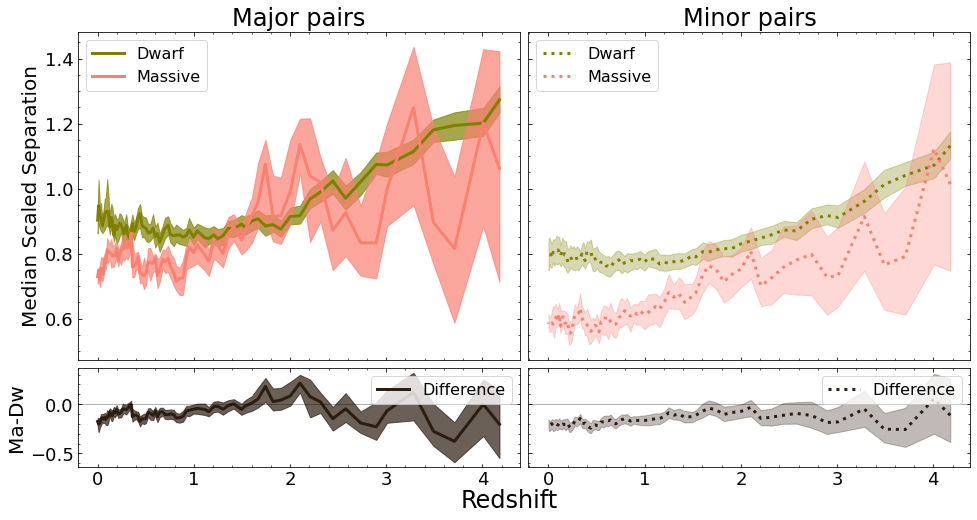

In [130]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(2, 2, figsize=(16,8), sharey="row", sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[1,0.3],'wspace': 0.02,"hspace":0.04})

ax_d = ax[0][0]
ax_m = ax[0][1]
ax_ddiff = ax[1][0]
ax_mdiff = ax[1][1]

ax_d.set(title="Major pairs", ylabel="Median Scaled Separation")
ax_m.set(title="Minor pairs")
ax_ddiff.set(ylabel=r"Ma-Dw")

#############
# dwarf #
#############
ax_d.plot(scaledseps['z'],scaledseps['Median Major Dwarf'], color=palette["dwarf"], lw=3, label="Dwarf")
ax_d.plot(scaledseps['z'],scaledseps['Median Major Massive'], color=palette["massive"], lw=3, label="Massive")

ax_d.fill_between(scaledseps['z'], np.array(scaledseps['Quartile Major Dwarf'])[:,0], np.array(scaledseps['Quartile Major Dwarf'])[:,1],color=palette["dwarf"],alpha=alphas["maj"])
ax_d.fill_between(scaledseps['z'], np.array(scaledseps['Quartile Major Massive'])[:,0], np.array(scaledseps['Quartile Major Massive'])[:,1],color=palette["massive"],alpha=alphas["maj"])

#############
# massive #
#############
ax_m.plot(scaledseps['z'],scaledseps['Median Minor Dwarf'], color=palette["dwarf"], lw=3, linestyle="dotted", label="Dwarf")
ax_m.plot(scaledseps['z'],scaledseps['Median Minor Massive'], color=palette["massive"], lw=3, linestyle="dotted", label="Massive")

ax_m.fill_between(scaledseps['z'], np.array(scaledseps['Quartile Minor Dwarf'])[:,0], np.array(scaledseps['Quartile Minor Dwarf'])[:,1],color=palette["dwarf"],alpha=alphas["min"])
ax_m.fill_between(scaledseps['z'], np.array(scaledseps['Quartile Minor Massive'])[:,0], np.array(scaledseps['Quartile Minor Massive'])[:,1],color=palette["massive"],alpha=alphas["min"])

##############
# major diff #
##############
ax_ddiff.plot(scaledseps['z'],scaledseps['Median Major Difference'], color=palette["difference"], lw=3, label="Difference")
ax_ddiff.fill_between(scaledseps['z'], np.array(scaledseps['Quartile Major Difference'])[:,0], np.array(scaledseps['Quartile Major Difference'])[:,1],color=palette["difference"],alpha=alphas["maj"])

##############
# minor diff #
##############
ax_mdiff.plot(scaledseps['z'],scaledseps['Median Minor Difference'], color=palette["difference"], lw=3, linestyle="dotted", label="Difference")
ax_mdiff.fill_between(scaledseps['z'], np.array(scaledseps['Quartile Minor Difference'])[:,0], np.array(scaledseps['Quartile Minor Difference'])[:,1],color=palette["difference"],alpha=alphas["min"])

ax_ddiff.axhline(0,color="black",lw=1,alpha=0.3)
ax_mdiff.axhline(0,color="black",lw=1,alpha=0.3)

#############
#############
for axx in [ax_d,ax_m,]:
    leg = axx.legend(loc='upper left',fontsize=16)

for axx in [ax_ddiff,ax_mdiff]:
    leg = axx.legend(loc='upper right',fontsize=16)
              
fig.supxlabel("Redshift",y=0.045)
plt.savefig(f"../plots/paper1/scaledsep_1000.png",bbox_inches='tight',facecolor="white")
plt.show()


## Scaled velocity

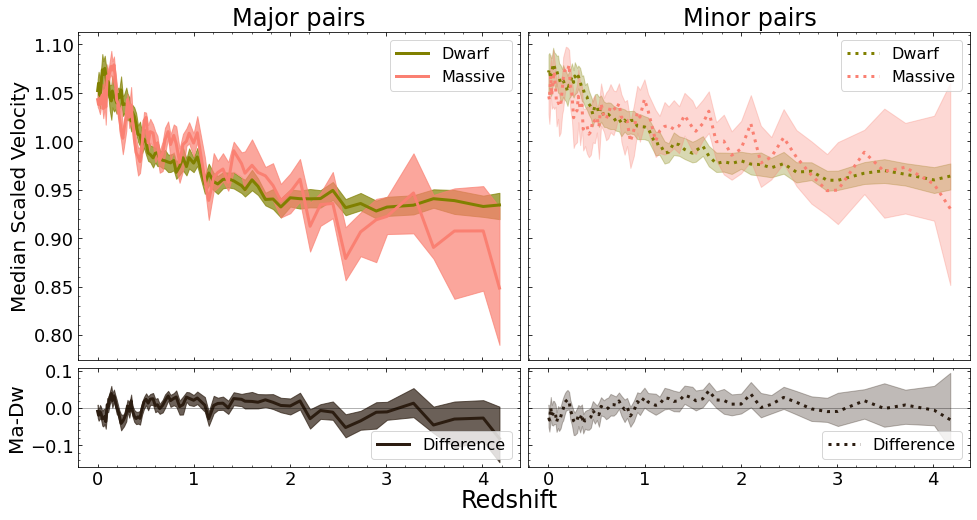

In [131]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(2, 2, figsize=(16,8), sharey="row", sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[1,0.3],'wspace': 0.02,"hspace":0.04})

ax_d = ax[0][0]
ax_m = ax[0][1]
ax_ddiff = ax[1][0]
ax_mdiff = ax[1][1]

ax_d.set(title="Major pairs", ylabel="Median Scaled Velocity")
ax_m.set(title="Minor pairs")
ax_ddiff.set(ylabel=r"Ma-Dw")

#############
# dwarf #
#############
ax_d.plot(scaledvels['z'],scaledvels['Median Major Dwarf'], color=palette["dwarf"], lw=3, label="Dwarf")
ax_d.plot(scaledvels['z'],scaledvels['Median Major Massive'], color=palette["massive"], lw=3, label="Massive")

ax_d.fill_between(scaledvels['z'], np.array(scaledvels['Quartile Major Dwarf'])[:,0], np.array(scaledvels['Quartile Major Dwarf'])[:,1],color=palette["dwarf"],alpha=alphas["maj"])
ax_d.fill_between(scaledvels['z'], np.array(scaledvels['Quartile Major Massive'])[:,0], np.array(scaledvels['Quartile Major Massive'])[:,1],color=palette["massive"],alpha=alphas["maj"])

#############
# massive #
#############
ax_m.plot(scaledvels['z'],scaledvels['Median Minor Dwarf'], color=palette["dwarf"], lw=3, linestyle="dotted", label="Dwarf")
ax_m.plot(scaledvels['z'],scaledvels['Median Minor Massive'], color=palette["massive"], lw=3, linestyle="dotted", label="Massive")

ax_m.fill_between(scaledvels['z'], np.array(scaledvels['Quartile Minor Dwarf'])[:,0], np.array(scaledvels['Quartile Minor Dwarf'])[:,1],color=palette["dwarf"],alpha=alphas["min"])
ax_m.fill_between(scaledvels['z'], np.array(scaledvels['Quartile Minor Massive'])[:,0], np.array(scaledvels['Quartile Minor Massive'])[:,1],color=palette["massive"],alpha=alphas["min"])

##############
# major diff #
##############
ax_ddiff.plot(scaledvels['z'],scaledvels['Median Major Difference'], color=palette["difference"], lw=3, label="Difference")
ax_ddiff.fill_between(scaledvels['z'], np.array(scaledvels['Quartile Major Difference'])[:,0], np.array(scaledvels['Quartile Major Difference'])[:,1],color=palette["difference"],alpha=alphas["maj"])

##############
# minor diff #
##############
ax_mdiff.plot(scaledvels['z'],scaledvels['Median Minor Difference'], color=palette["difference"], lw=3, linestyle="dotted", label="Difference")
ax_mdiff.fill_between(scaledvels['z'], np.array(scaledvels['Quartile Minor Difference'])[:,0], np.array(scaledvels['Quartile Minor Difference'])[:,1],color=palette["difference"],alpha=alphas["min"])

ax_ddiff.axhline(0,color="black",lw=1,alpha=0.3)
ax_mdiff.axhline(0,color="black",lw=1,alpha=0.3)

#############
#############
for ax in [ax_d,ax_m]:
    leg = ax.legend(loc='upper right',fontsize=16)

for ax in [ax_ddiff,ax_mdiff]:
    leg = ax.legend(loc='lower right',fontsize=16)
              
fig.supxlabel("Redshift",y=0.045)
plt.savefig(f"../plots/paper1/scaledvel_1000.png",bbox_inches='tight',facecolor="white")
plt.show()


# Distributions

In [39]:
def get_sepvel(size, key, z, scaled=False):
    zloc = np.where( zs['z'] == z)[0]
    sim = "TNG"
    snapshot = zs['ztng'][zloc][0] 

    pair_path = f"{sim}_{snapshot}_1000.hdf5"
    pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")
    
    pairs = pair_data["pairs"]["hydro"]

    pri_stell = np.array(pairs["Sub1 Stellar Mass"])
    sec_stell = np.array(pairs["Sub2 Stellar Mass"])
    pairGroups = np.array(pairs["Group Mass"])
    pairGrRads = np.array(pairs["Group Radius"])
    seps = np.array(pairs["Separation"]) 
    vels = np.array(pairs["RelVel"]) 
    
    # masks            
    pair_pri = get_primmask(pri_stell, size)
    pair_group = get_groupmask(pairGroups, size)
    pair_sepcut = seps > 10
    
    pair_mask = pair_pri & pair_group & pair_sepcut
    
    majors = (sec_stell/pri_stell > 1/4)
    minors = (sec_stell/pri_stell > 1/10) & (sec_stell/pri_stell < 1/4)

    major_mask = pair_mask & majors
    minor_mask = pair_mask & minors
    
    if key == "Separation":
        scaleddat = seps / pairGrRads
    elif key == "RelVel":
        G = 4.3009173e4 # in km^2 kpc / (1e10M⊙ s^2)
        vvir = np.sqrt(G*pairGroups / pairGrRads)
        scaleddat = vels / (vvir)    
    
    if scaled: 
        dat = scaleddat
    elif key == "Separation":
        dat = seps
    elif key == "RelVel":
        dat = vels
    else:
        dat = np.array(pairs[key]) 

    majors = dat[major_mask]
    minors = dat[minor_mask]

    key_dict = {"major":majors, "minor":minors}
    

    return key_dict


## Separation

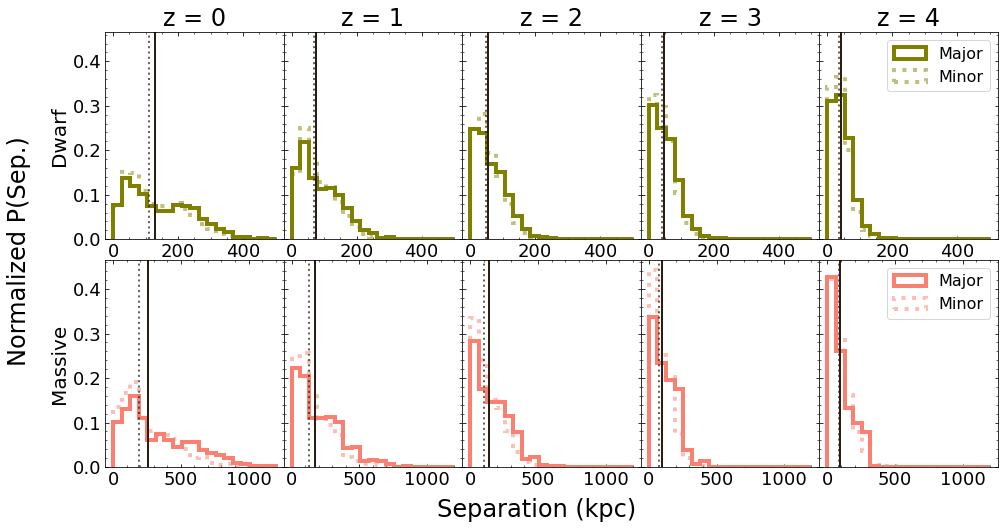

In [68]:
fig, ax = plt.subplots(2,5,figsize=(16,8),sharey=True,sharex=False)
plt.subplots_adjust(wspace=0,hspace=0.1)

for i in range(5):
    locc = np.where( np.min( np.abs(d_seps['z'] - i)  ) == np.abs(d_seps['z'] - i))
    
    tng_d = get_sepvel("dwarf", "Separation", i, scaled=False)
    tng_m = get_sepvel("massive", "Separation", i, scaled=False)
    
    bins_d = np.linspace(0,500,20)
    bins_h = np.linspace(0,1200,20)
    
    ax[0][i].set_title(f"z = {i}")

    # Illustris Major pairs
    col = palette["difference"]
    ala = 1

    ax[0][i].hist(tng_d['major'],bins=bins_d,weights=np.ones(len(tng_d['major']))/len(tng_d['major']),histtype="step", color=palette['dwarf'], lw=4, label='Major')
    ax[0][i].hist(tng_d['minor'],bins=bins_d,weights=np.ones(len(tng_d['minor']))/len(tng_d['minor']),histtype="step", color=palette['dwarf'], lw=4, alpha=0.5, linestyle="dotted", label="Minor") # to put minor behind
    
    ax[1][i].hist(tng_m['major'],bins=bins_h,weights=np.ones(len(tng_m['major']))/len(tng_m['major']),histtype="step", color=palette['massive'], lw=4, label='Major')
    ax[1][i].hist(tng_m['minor'],bins=bins_h,weights=np.ones(len(tng_m['minor']))/len(tng_m['minor']),histtype="step", color=palette['massive'], lw=4, alpha=0.5, linestyle="dotted", label="Minor") # to put minor behind

    ax[0][i].axvline( d_seps["Major Median"][locc] ,color=col, alpha=ala, lw=2)
    ax[0][i].axvline( d_seps["Minor Median"][locc] ,color=col, alpha=0.7, lw=2, linestyle="dotted")
    ax[1][i].axvline( m_seps["Major Median"][locc] ,color=col, alpha=ala, lw=2)
    ax[1][i].axvline( m_seps["Minor Median"][locc] ,color=col, alpha=0.7, lw=2, linestyle="dotted")

for xx in [ax[0][4],ax[1][4]]:
    leg = xx.legend(loc='upper right',fontsize=16)

fig.supxlabel(r"Separation (kpc)",y=0.03)
ax[0][0].set_ylabel("Dwarf")
ax[1][0].set_ylabel("Massive")
fig.supylabel("Normalized P(Sep.)",x=0.040)

plt.savefig(f"../plots/paper1/separation_distribution_1000.png",bbox_inches='tight',facecolor="white")
plt.show()

## Velocity

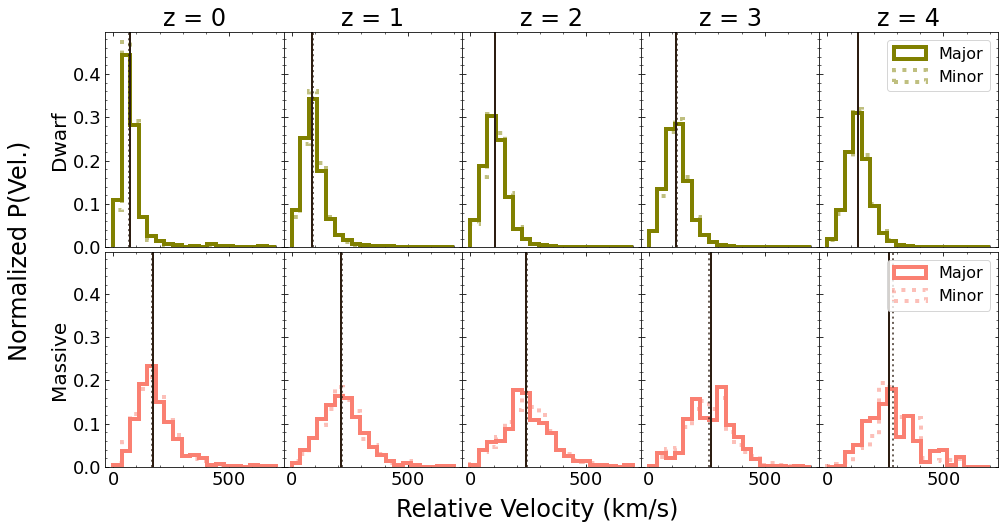

In [124]:
fig, ax = plt.subplots(2,5,figsize=(16,8),sharey=True,sharex=True)
plt.subplots_adjust(wspace=0,hspace=0.02)

for i in range(5):
    locc = np.where( np.min( np.abs(d_vels['z'] - i)  ) == np.abs(d_vels['z'] - i))
        
    tng_d = get_sepvel("dwarf", "RelVel", i, scaled=False)
    tng_m = get_sepvel("massive", "RelVel", i, scaled=False)
    
    bins_d = np.linspace(0,700,20)
    bins_h = np.linspace(0,700,20)
    
    ax[0][i].set_title(f"z = {i}")

    # Illustris Major pairs
    col = palette["difference"]
    ala = 1
    ax[0][i].hist(tng_d['major'],bins=bins_d,weights=np.ones(len(tng_d['major']))/len(tng_d['major']),histtype="step", color=palette['dwarf'], lw=4, label='Major')
    ax[0][i].hist(tng_d['minor'],bins=bins_d,weights=np.ones(len(tng_d['minor']))/len(tng_d['minor']),histtype="step", color=palette['dwarf'], lw=4, alpha=0.5, linestyle="dotted", label="Minor") # to put minor behind

    ax[1][i].hist(tng_m['major'],bins=bins_h,weights=np.ones(len(tng_m['major']))/len(tng_m['major']),histtype="step", color=palette['massive'], lw=4, label='Major')
    ax[1][i].hist(tng_m['minor'],bins=bins_h,weights=np.ones(len(tng_m['minor']))/len(tng_m['minor']),histtype="step", color=palette['massive'], lw=4, alpha=0.5, linestyle="dotted", label="Minor") # to put minor behind
    
    ax[0][i].axvline( d_vels["Major Median"][locc] ,color=col, alpha=ala, lw=2)
    ax[0][i].axvline( d_vels["Minor Median"][locc] ,color=col, alpha=0.7, linestyle="dotted", lw=2)
    ax[1][i].axvline( m_vels["Major Median"][locc] ,color=col, alpha=ala, lw=2)
    ax[1][i].axvline( m_vels["Minor Median"][locc] ,color=col, alpha=0.7, linestyle="dotted", lw=2)
    
for xx in [ax[0][4],ax[1][4]]:
    leg = xx.legend(loc='upper right',fontsize=16)

fig.supxlabel(r"Relative Velocity (km/s)",y=0.03)
ax[0][0].set_ylabel("Dwarf")
ax[1][0].set_ylabel("Massive")
fig.supylabel("Normalized P(Vel.)",x=0.040)

plt.savefig(f"../plots/paper1/velocity_distribution_1000.png",bbox_inches='tight',facecolor="white")
plt.show()

## Scaled separation

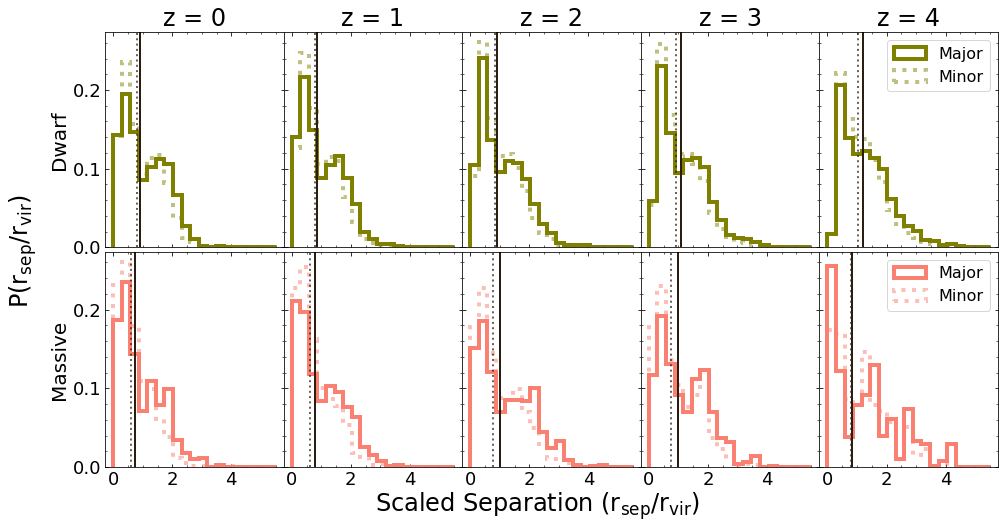

In [123]:
fig, ax = plt.subplots(2,5,figsize=(16,8),sharey=True,sharex=True)
plt.subplots_adjust(wspace=0,hspace=0.02)

for i in range(5):
    locc = np.where( np.min( np.abs(scaledseps['z'] - i)  ) == np.abs(scaledseps['z'] - i))
    
    tng_d = get_sepvel("dwarf", "Separation", i, scaled=True)
    tng_m = get_sepvel("massive", "Separation", i, scaled=True)
    
    bins_d = np.linspace(0,5.5,20)
    bins_h = np.linspace(0,5.5,20)
    
    ax[0][i].set_title(f"z = {i}")

    # Illustris Major pairs
    ax[0][i].hist(tng_d['major'],bins=bins_d,weights=np.ones(len(tng_d['major']))/len(tng_d['major']),histtype="step", color=palette['dwarf'], lw=4, label='Major')
    ax[0][i].hist(tng_d['minor'],bins=bins_d,weights=np.ones(len(tng_d['minor']))/len(tng_d['minor']),histtype="step", color=palette['dwarf'], lw=4, alpha=0.5, linestyle="dotted", label="Minor") # to put minor behind

    ax[1][i].hist(tng_m['major'],bins=bins_h,weights=np.ones(len(tng_m['major']))/len(tng_m['major']),histtype="step", color=palette['massive'], lw=4, label='Major')
    ax[1][i].hist(tng_m['minor'],bins=bins_h,weights=np.ones(len(tng_m['minor']))/len(tng_m['minor']),histtype="step", color=palette['massive'], lw=4, alpha=0.5, linestyle="dotted", label="Minor") # to put minor behind
   
    ax[0][i].axvline( scaledseps["Median Major Dwarf"][locc] ,color=palette["difference"], lw=2)
    ax[0][i].axvline( scaledseps["Median Minor Dwarf"][locc] ,color=palette["difference"], linestyle="dotted", alpha=0.7, lw=2)
    ax[1][i].axvline( scaledseps["Median Major Massive"][locc] ,color=palette["difference"], lw=2)
    ax[1][i].axvline( scaledseps["Median Minor Massive"][locc] ,color=palette["difference"], linestyle="dotted", alpha=0.7, lw=2)

    
for i in ax:
    for j in i:
        j.set_xticks((0,2,4), labels=("0","2","4"))
    
    
for xx in [ax[0][4],ax[1][4]]:
    leg = xx.legend(loc='upper right',fontsize=16)

fig.supxlabel(r"Scaled Separation ($\rm r_{sep}/r_{vir}$)",y=0.03)
ax[0][0].set_ylabel("Dwarf")
ax[1][0].set_ylabel("Massive")
fig.supylabel(r"P($\rm r_{sep}/r_{vir}$)",x=0.040)

plt.savefig(f"../plots/paper1/scaledsep_distribution_1000.png",bbox_inches='tight',facecolor="white")
plt.show()

## Scaled velocity

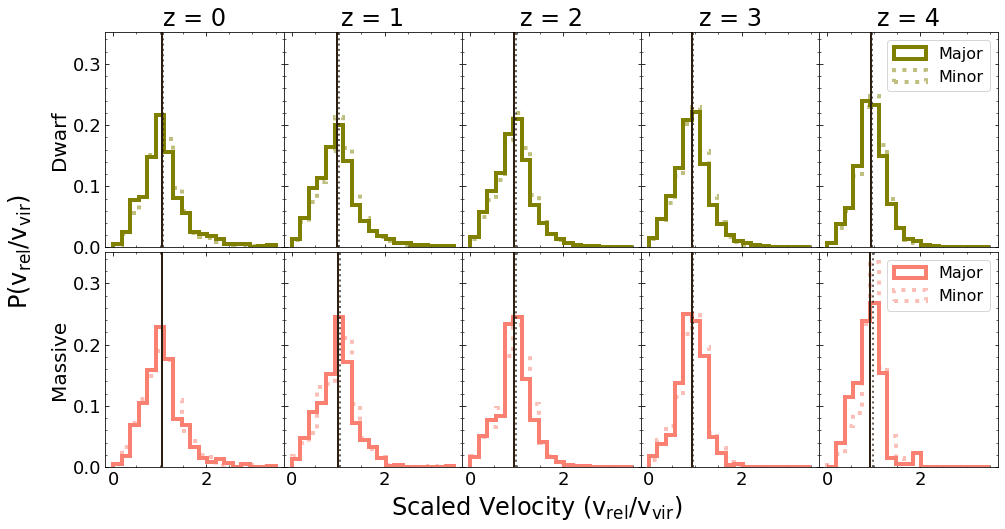

In [125]:
fig, ax = plt.subplots(2,5,figsize=(16,8),sharey=True,sharex=False)
plt.subplots_adjust(wspace=0,hspace=0.02)

for i in range(5):
    locc = np.where( np.min( np.abs(scaledvels['z'] - i)  ) == np.abs(scaledvels['z'] - i))
        
    tng_d = get_sepvel("dwarf", "RelVel", i, scaled=True)
    tng_m = get_sepvel("massive", "RelVel", i, scaled=True)
    
    bins_d = np.linspace(0,3.5,20)
    bins_h = np.linspace(0,3.5,20)
    
    ax[0][i].set_title(f"z = {i}")

    # Illustris Major pairs
    ax[0][i].hist(tng_d['major'],bins=bins_d,weights=np.ones(len(tng_d['major']))/len(tng_d['major']),histtype="step", color=palette['dwarf'], lw=4, label='Major')
    ax[0][i].hist(tng_d['minor'],bins=bins_d,weights=np.ones(len(tng_d['minor']))/len(tng_d['minor']),histtype="step", color=palette['dwarf'], lw=4, alpha=0.5, linestyle="dotted", label="Minor") # to put minor behind

    ax[1][i].hist(tng_m['major'],bins=bins_h,weights=np.ones(len(tng_m['major']))/len(tng_m['major']),histtype="step", color=palette['massive'], lw=4, label='Major')
    ax[1][i].hist(tng_m['minor'],bins=bins_h,weights=np.ones(len(tng_m['minor']))/len(tng_m['minor']),histtype="step", color=palette['massive'], lw=4, alpha=0.5, linestyle="dotted", label="Minor") # to put minor behind
    
    ax[0][i].axvline( scaledvels["Median Major Dwarf"][locc] ,color=palette['difference'], lw=2)
    ax[0][i].axvline( scaledvels["Median Minor Dwarf"][locc] ,color=palette['difference'], linestyle="dotted", alpha=0.7, lw=2)
    ax[1][i].axvline( scaledvels["Median Major Massive"][locc] ,color=palette['difference'], lw=2)
    ax[1][i].axvline( scaledvels["Median Minor Massive"][locc] ,color=palette['difference'], linestyle="dotted", alpha=0.7, lw=2)
     

for xx in [ax[0][4],ax[1][4]]:
    leg = xx.legend(loc='upper right',fontsize=16)


fig.supxlabel(r"Scaled Velocity ($\rm v_{rel}/v_{vir}$)",y=0.03)
ax[0][0].set_ylabel("Dwarf")
ax[1][0].set_ylabel("Massive")
fig.supylabel(r"P($\rm v_{rel}/v_{vir}$)",x=0.040)

plt.savefig(f"../plots/paper1/scaledvel_distribution_1000.png",bbox_inches='tight',facecolor="white")
plt.show()

# Separation cuts

# Graveyard

In [23]:
# ## plot of median counts and differences for illustris and tng
# fig, ax = plt.subplots(2, 2, figsize=(16,16), sharey="row", sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[1,1],'wspace': 0.05,"hspace":0.02})

# axmaj_d = ax[0][0]
# axmin_d = ax[0][1]
# axmaj_m = ax[1][0]
# axmin_m = ax[1][1]


# axmaj_d.set(title="Major pairs", ylabel="Median Separation [kpc]")
# axmin_d.set(title="Minor pairs")
# axmaj_m.set(ylabel="Median Separation [kpc]")

# al = 0.5

# #############
# # dwarf major #
# #############
# axmaj_d.plot(tngd_d['z'],tngd_d['Major Median'], color=palette["Illustris dark"], lw=3)
# axmaj_d.plot(tngh_d['z'],tngh_d['Major Median'], color=palette["Illustris hydro"], lw=3)

# axmaj_d.fill_between(tngd_d['z'], np.array(tngd_d['Major Quarts'])[:,0], np.array(tngd_d['Major Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
# axmaj_d.fill_between(tngh_d['z'], np.array(tngh_d['Major Quarts'])[:,0], np.array(tngh_d['Major Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")


# #############
# # dwarf minor #
# #############
# axmin_d.plot(tngd_d['z'],tngd_d['Minor Median'], color=palette["Illustris dark"], lw=3)
# axmin_d.plot(tngh_d['z'],tngh_d['Minor Median'], color=palette["Illustris hydro"], lw=3)

# axmin_d.fill_between(tngd_d['z'], np.array(tngd_d['Minor Quarts'])[:,0], np.array(tngd_d['Minor Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
# axmin_d.fill_between(tngh_d['z'], np.array(tngh_d['Minor Quarts'])[:,0], np.array(tngh_d['Minor Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

# #############
# # massive major #
# #############
# axmaj_m.plot(tngd_d['z'],tngd_m['Major Median'], color=palette["TNG dark"], lw=3)
# axmaj_m.plot(tngh_d['z'],tngh_m['Major Median'], color=palette["TNG hydro"], lw=3)

# axmaj_m.fill_between(tngd_m['z'], np.array(tngd_m['Major Quarts'])[:,0], np.array(tngd_m['Major Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
# axmaj_m.fill_between(tngh_m['z'], np.array(tngh_m['Major Quarts'])[:,0], np.array(tngh_m['Major Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")


# #############
# # massive minor #
# #############
# axmin_m.plot(tngd_m['z'],tngd_m['Minor Median'], color=palette["TNG dark"], lw=3)
# axmin_m.plot(tngh_m['z'],tngh_m['Minor Median'], color=palette["TNG hydro"], lw=3)
# # axmin_m.plot(tngsim_m['z'],tngsim_m['Minor Median'], color='black', lw=3)

# axmin_m.fill_between(tngd_m['z'], np.array(tngd_m['Minor Quarts'])[:,0], np.array(tngd_m['Minor Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
# axmin_m.fill_between(tngh_m['z'], np.array(tngh_m['Minor Quarts'])[:,0], np.array(tngh_m['Minor Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")


# ############
# ############
# for ax, tit in zip([axmin_d,axmin_m],["Dwarf","Massive"]):
#     leg = ax.legend(loc='upper right',title=tit,fontsize=16)

#     for lh in leg.legendHandles: 
#         lh.set_alpha(1)
              
# fig.supxlabel("Redshift",y=0.08)
# plt.savefig(f"../plots/paper1/separations.png",bbox_inches='tight',facecolor="white")
# plt.show()


In [24]:
# ## plot of median counts and differences for illustris and tng
# fig, ax = plt.subplots(2, 2, figsize=(16,16), sharey="row", sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[1,1],'wspace': 0.05,"hspace":0.02})

# # axmaj_d = ax[0][0]
# # axmin_d = ax[0][1]
# # axmaj_m = ax[1][0]
# # axmin_m = ax[1][1]

# axmaj_d = ax[0][0]
# axmin_d = ax[1][0]
# axmaj_m = ax[0][1]
# axmin_m = ax[1][1]


# axmaj_d.set(title="Dwarf pairs", ylabel="Major pair separation")
# axmaj_m.set(title="Massive pairs")
# axmin_d.set(ylabel="Minor pair separation")

# al = 0.5

# #############
# # dwarf major #
# #############
# axmaj_d.plot(tngd_d['z'],tngd_d['Major Median'], color=palette["Illustris dark"], lw=3)
# axmaj_d.plot(tngh_d['z'],tngh_d['Major Median'], color=palette["Illustris hydro"], lw=3)

# axmaj_d.fill_between(tngd_d['z'], np.array(tngd_d['Major Quarts'])[:,0], np.array(tngd_d['Major Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
# axmaj_d.fill_between(tngh_d['z'], np.array(tngh_d['Major Quarts'])[:,0], np.array(tngh_d['Major Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")


# #############
# # dwarf minor #
# #############
# axmin_d.plot(tngd_d['z'],tngd_d['Minor Median'], color=palette["Illustris dark"], lw=3)
# axmin_d.plot(tngh_d['z'],tngh_d['Minor Median'], color=palette["Illustris hydro"], lw=3)

# axmin_d.fill_between(tngd_d['z'], np.array(tngd_d['Minor Quarts'])[:,0], np.array(tngd_d['Minor Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
# axmin_d.fill_between(tngh_d['z'], np.array(tngh_d['Minor Quarts'])[:,0], np.array(tngh_d['Minor Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

# #############
# # massive major #
# #############
# axmaj_m.plot(tngd_d['z'],tngd_m['Major Median'], color=palette["TNG dark"], lw=3)
# axmaj_m.plot(tngh_d['z'],tngh_m['Major Median'], color=palette["TNG hydro"], lw=3)

# axmaj_m.fill_between(tngd_m['z'], np.array(tngd_m['Major Quarts'])[:,0], np.array(tngd_m['Major Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
# axmaj_m.fill_between(tngh_m['z'], np.array(tngh_m['Major Quarts'])[:,0], np.array(tngh_m['Major Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")


# #############
# # massive minor #
# #############
# axmin_m.plot(tngd_m['z'],tngd_m['Minor Median'], color=palette["TNG dark"], lw=3)
# axmin_m.plot(tngh_m['z'],tngh_m['Minor Median'], color=palette["TNG hydro"], lw=3)

# axmin_m.fill_between(tngd_m['z'], np.array(tngd_m['Minor Quarts'])[:,0], np.array(tngd_m['Minor Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
# axmin_m.fill_between(tngh_m['z'], np.array(tngh_m['Minor Quarts'])[:,0], np.array(tngh_m['Minor Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")



# #############
# #############
# for ax, tit in zip([axmaj_m,axmin_m],["Major","Minor"]):
#     leg = ax.legend(loc='upper right',title=tit,fontsize=16)

#     for lh in leg.legendHandles: 
#         lh.set_alpha(1)
        
# for ax, tit in zip([axmaj_d,axmin_d],["Major","Minor"]):
#     leg = ax.legend(loc='upper right',title=tit,fontsize=16)

#     for lh in leg.legendHandles: 
#         lh.set_alpha(1)
              
# fig.supxlabel("Redshift",y=0.08)
# plt.savefig(f"../plots/paper1/separations_T.png",bbox_inches='tight',facecolor="white")
# plt.show()


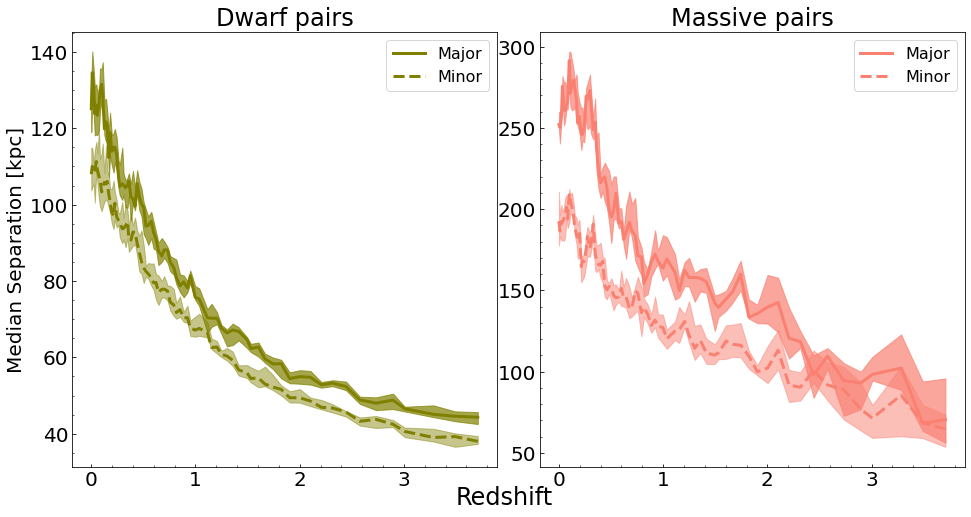

In [14]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(1, 2, figsize=(16,8), sharey=False, sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[1],'wspace': 0.1})

ax_d = ax[0]
ax_m = ax[1]


ax_d.set(title="Dwarf pairs", ylabel="Median Separation [kpc]")
ax_m.set(title="Massive pairs")

al = 0.7

#############
# dwarf #
#############
ax_d.plot(d_seps['z'],d_seps['Major Median'], color=palette["dwarf"], lw=3, label="Major")
ax_d.plot(d_seps['z'],d_seps['Minor Median'], color=palette["dwarf"], lw=3, linestyle="dotted", label="Minor")

ax_d.fill_between(d_seps['z'], np.array(d_seps['Major Quarts'])[:,0], np.array(d_seps['Major Quarts'])[:,1],color=palette["dwarf"], alpha=alphas["maj"])
ax_d.fill_between(d_seps['z'], np.array(d_seps['Minor Quarts'])[:,0], np.array(d_seps['Minor Quarts'])[:,1],color=palette["dwarf"], alpha=alphas["min"])


#############
# massive #
#############
ax_m.plot(m_seps['z'],m_seps['Major Median'], color=palette["massive"], lw=3, label="Major")
ax_m.plot(m_seps['z'],m_seps['Minor Median'], color=palette["massive"], lw=3, linestyle="dotted", label="Minor")

ax_m.fill_between(m_seps['z'], np.array(m_seps['Major Quarts'])[:,0], np.array(m_seps['Major Quarts'])[:,1],color=palette["massive"],alpha=alphas["maj"])
ax_m.fill_between(m_seps['z'], np.array(m_seps['Minor Quarts'])[:,0], np.array(m_seps['Minor Quarts'])[:,1],color=palette["massive"],alpha=alphas["min"])


#############
#############
for ax in [ax_d,ax_m]:
    leg = ax.legend(loc='upper right',fontsize=16)

#     for lh in leg.legendHandles: 
#         lh.set_alpha(1)
              
fig.supxlabel("Redshift",y=0.05)
plt.savefig(f"../plots/paper1/separations.png",bbox_inches='tight',facecolor="white")
plt.show()


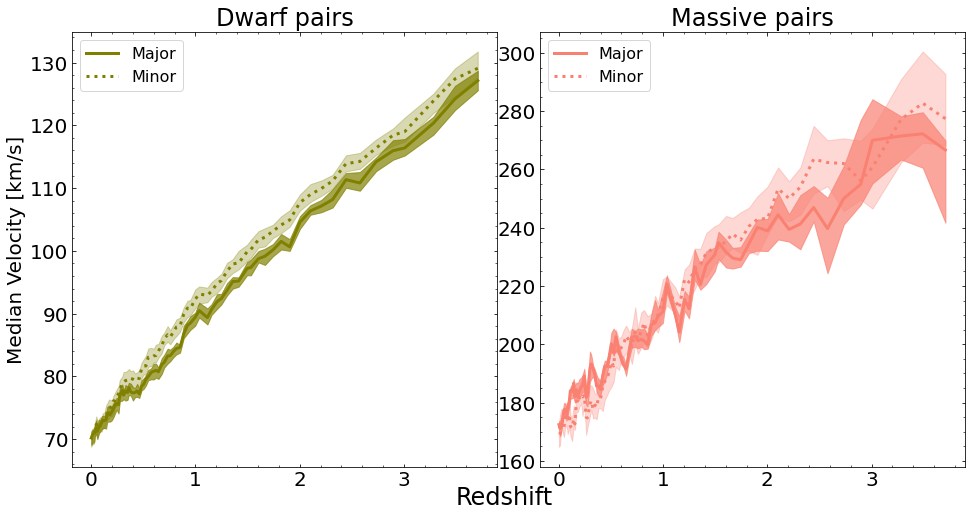

In [82]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(1, 2, figsize=(16,8), sharey=False, sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[1],'wspace': 0.1})

ax_d = ax[0]
ax_m = ax[1]


ax_d.set(title="Dwarf pairs", ylabel="Median Velocity [km/s]")
ax_m.set(title="Massive pairs")

al = 0.7

#############
# dwarf #
#############
ax_d.plot(d_vels['z'],d_vels['Major Median'], color=palette["dwarf"], lw=3, label="Major")
ax_d.plot(d_vels['z'],d_vels['Minor Median'], color=palette["dwarf"], lw=3,linestyle="dotted", label="Minor")

ax_d.fill_between(d_vels['z'], np.array(d_vels['Major Quarts'])[:,0], np.array(d_vels['Major Quarts'])[:,1], color=palette["dwarf"], alpha=alphas["maj"])
ax_d.fill_between(d_vels['z'], np.array(d_vels['Minor Quarts'])[:,0], np.array(d_vels['Minor Quarts'])[:,1], color=palette["dwarf"], alpha=alphas["min"])

#############
# massive #
#############
ax_m.plot(m_vels['z'],m_vels['Major Median'], color=palette["massive"], lw=3, label="Major")
ax_m.plot(m_vels['z'],m_vels['Minor Median'], color=palette["massive"], lw=3, linestyle="dotted", label="Minor")

ax_m.fill_between(m_vels['z'], np.array(m_vels['Major Quarts'])[:,0], np.array(m_vels['Major Quarts'])[:,1], color=palette["massive"], alpha=alphas["maj"])
ax_m.fill_between(m_vels['z'], np.array(m_vels['Minor Quarts'])[:,0], np.array(m_vels['Minor Quarts'])[:,1], color=palette["massive"], alpha=alphas["min"])


#############
#############
for ax in [ax_d,ax_m]:
    leg = ax.legend(loc='upper left',fontsize=16)

#     for lh in leg.legendHandles: 
#         lh.set_alpha(1)
              
fig.supxlabel("Redshift",y=0.05)
# plt.savefig(f"../plots/paper1/velocities.png",bbox_inches='tight',facecolor="white")
plt.show()


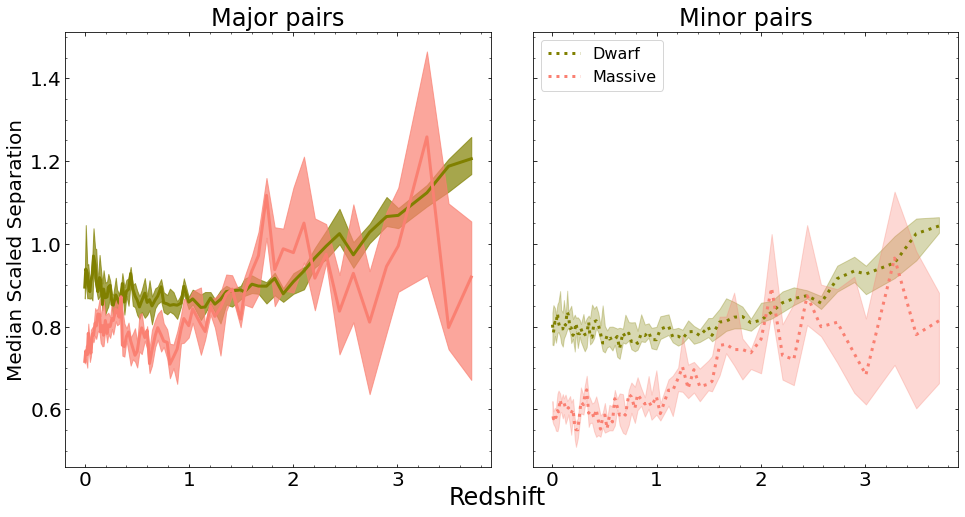

In [186]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(1, 2, figsize=(16,8), sharey=True, sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[1],'wspace': 0.1})

ax_d = ax[0]
ax_m = ax[1]


ax_d.set(title="Major pairs", ylabel="Median Scaled Separation")
ax_m.set(title="Minor pairs")

al = 0.7

#############
# dwarf #
#############
ax_d.plot(scaledseps['z'],scaledseps['Median Major Dwarf'], color=palette["dwarf"], lw=3, label="Dwarf")
ax_d.plot(scaledseps['z'],scaledseps['Median Major Massive'], color=palette["massive"], lw=3, label="Massive")

ax_d.fill_between(scaledseps['z'], np.array(scaledseps['Quartile Major Dwarf'])[:,0], np.array(scaledseps['Quartile Major Dwarf'])[:,1],color=palette["dwarf"],alpha=alphas["maj"])
ax_d.fill_between(scaledseps['z'], np.array(scaledseps['Quartile Major Massive'])[:,0], np.array(scaledseps['Quartile Major Massive'])[:,1],color=palette["massive"],alpha=alphas["maj"])

#############
# massive #
#############
ax_m.plot(scaledseps['z'],scaledseps['Median Minor Dwarf'], color=palette["dwarf"], lw=3, linestyle="dotted", label="Dwarf")
ax_m.plot(scaledseps['z'],scaledseps['Median Minor Massive'], color=palette["massive"], lw=3, linestyle="dotted", label="Massive")

ax_m.fill_between(scaledseps['z'], np.array(scaledseps['Quartile Minor Dwarf'])[:,0], np.array(scaledseps['Quartile Minor Dwarf'])[:,1],color=palette["dwarf"],alpha=alphas["min"])
ax_m.fill_between(scaledseps['z'], np.array(scaledseps['Quartile Minor Massive'])[:,0], np.array(scaledseps['Quartile Minor Massive'])[:,1],color=palette["massive"],alpha=alphas["min"])

#############
#############
for ax in [ax_m]:
    leg = ax.legend(loc='upper left',fontsize=16)

    for lh in leg.legendHandles: 
        lh.set_alpha(1)
              
fig.supxlabel("Redshift",y=0.05)
# plt.savefig(f"../plots/paper1/separations_scaled.png",bbox_inches='tight',facecolor="white")
plt.show()


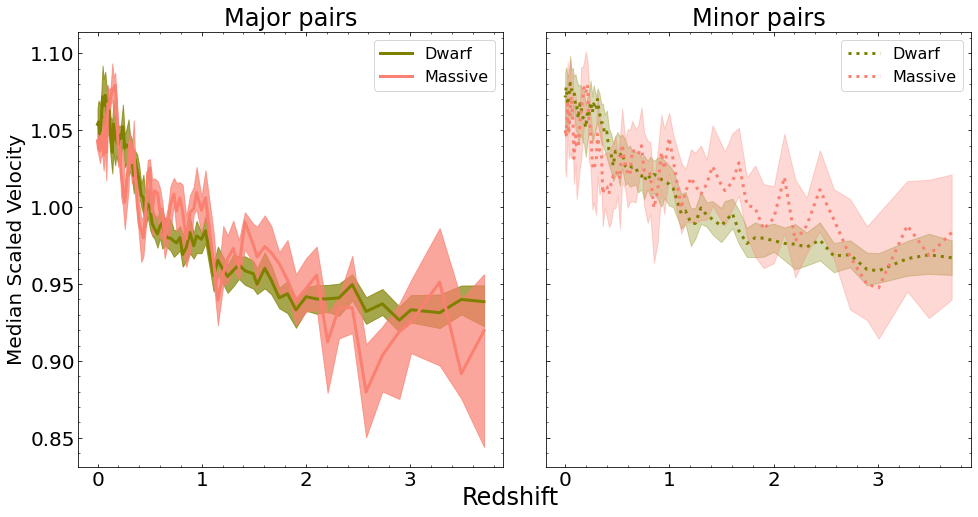

In [208]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(1, 2, figsize=(16,8), sharey=True, sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[1],'wspace': 0.1})

ax_d = ax[0]
ax_m = ax[1]

ax_d.set(title="Major pairs", ylabel="Median Scaled Velocity")
ax_m.set(title="Minor pairs")

al = 0.7

#############
# dwarf #
#############
ax_d.plot(scaledvels['z'],scaledvels['Median Major Dwarf'], color=palette["dwarf"], lw=3, label="Dwarf")
ax_d.plot(scaledvels['z'],scaledvels['Median Major Massive'], color=palette["massive"], lw=3, label="Massive")

ax_d.fill_between(scaledvels['z'], np.array(scaledvels['Quartile Major Dwarf'])[:,0], np.array(scaledvels['Quartile Major Dwarf'])[:,1],color=palette["dwarf"],alpha=alphas["maj"])
ax_d.fill_between(scaledvels['z'], np.array(scaledvels['Quartile Major Massive'])[:,0], np.array(scaledvels['Quartile Major Massive'])[:,1],color=palette["massive"],alpha=alphas["maj"])


#############
# massive #
#############
ax_m.plot(scaledvels['z'],scaledvels['Median Minor Dwarf'], color=palette["dwarf"], lw=3, linestyle="dotted", label="Dwarf")
ax_m.plot(scaledvels['z'],scaledvels['Median Minor Massive'], color=palette["massive"], lw=3, linestyle="dotted", label="Massive")

ax_m.fill_between(scaledvels['z'], np.array(scaledvels['Quartile Minor Dwarf'])[:,0], np.array(scaledvels['Quartile Minor Dwarf'])[:,1],color=palette["dwarf"],alpha=alphas["min"])
ax_m.fill_between(scaledvels['z'], np.array(scaledvels['Quartile Minor Massive'])[:,0], np.array(scaledvels['Quartile Minor Massive'])[:,1],color=palette["massive"],alpha=alphas["min"])

#############
#############
for ax in [ax_d,ax_m]:
    leg = ax.legend(loc='upper right',fontsize=16)

    for lh in leg.legendHandles: 
        lh.set_alpha(1)
              
fig.supxlabel("Redshift",y=0.05)
# plt.savefig(f"../plots/paper1/velocities_scaled.png",bbox_inches='tight',facecolor="white")
plt.show()
